## From Landmarks to Animations

Víctor Ubieto | 2022

victoremilio.ubieto@upf.edu // victor.ubieto@e-campus.uab.cat

In [5]:
import os
import json
import math
import graphviz
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from sklearn.model_selection import train_test_split

Let us first read the train and test files

In [6]:
train_data_dir = "E:\Documents\Projects\PycharmCurrent\Dataset"
train_data_dir_gt = "E:\Documents\Projects\PycharmCurrent\Dataset\gt"
data = []
gt_data = []

os.chdir(train_data_dir)
for file in os.listdir():
    if file.endswith(".json"):
        with open(file, 'r') as f:
            d = json.load(f)  # returns JSON object as a dictionary
            data = data + d

os.chdir(train_data_dir_gt)
for file in os.listdir():
    with open(file, 'r') as f:
        d = json.load(f)
        gt_data = gt_data + d

print(len(data)) # check data is something
print(len(gt_data)) # check data is something

2051
2051


Hyperparameters definition

In [68]:
n_epochs = 6000
batch_size = 60
init_lr = 0.001
decay_stp = 10000
decay_rt = 0.9

#def step_decay(epoch):
#   initial_lrate = 0.001
#   drop = 0.5
#   epochs_drop = 50.0
#   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#   return lrate
#lr_scheduler = LearningRateScheduler(step_decay)

lr_rate = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=decay_stp,
    decay_rate=decay_rt)

optimizer = optimizers.Adam(learning_rate=lr_rate)
#optimizer = optimizers.Adamax(learning_rate=lr_rate)

#callbacks_list = [lr_scheduler]

Data preparation + data preprocessing, normalization?

Divide data in train-val-test

In [69]:
X_train, x_test, Y_train, y_test = train_test_split(data, gt_data, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25)  # 0.25 x 0.8 = 0.2
x_length = len(x_train[0])
y_length = len(y_train[0])

Model creation (https://www.tensorflow.org/tutorials/keras/regression)

In [70]:
model = Sequential()
model.add(layers.LayerNormalization(input_dim=x_length))
model.add(layers.Dense(256, activation="relu", name="layer1"))
model.add(layers.Dense(512, activation='relu', name="layer2"))
model.add(layers.Dense(1024, activation='relu', name="layer3"))
model.add(layers.Dense(2048, activation='relu', name="layer4"))
model.add(layers.Dense(1024, activation='relu', name="layer5"))
model.add(layers.Dense(512, activation='relu', name="layer6"))
model.add(layers.Dense(y_length, activation='linear', name="layer_out"))

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model.summary()
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_13 (Lay  (None, 225)              450       
 erNormalization)                                                
                                                                 
 layer1 (Dense)              (None, 256)               57856     
                                                                 
 layer2 (Dense)              (None, 512)               131584    
                                                                 
 layer3 (Dense)              (None, 1024)              525312    
                                                                 
 layer4 (Dense)              (None, 2048)              2099200   
                                                                 
 layer5 (Dense)              (None, 1024)              2098176   
                                                     

Training step

In [71]:
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=n_epochs,
                validation_data=(x_val, y_val),
                #callbacks=callbacks_list
                )

Epoch 1/6000
21/21 [==============================] - 2s 40ms/step - loss: 0.0407 - accuracy: 0.0626 - val_loss: 0.0114 - val_accuracy: 0.0024
Epoch 2/6000
21/21 [==============================] - 0s 10ms/step - loss: 0.0098 - accuracy: 0.1000 - val_loss: 0.0088 - val_accuracy: 0.2366
Epoch 3/6000
21/21 [==============================] - 0s 8ms/step - loss: 0.0073 - accuracy: 0.0285 - val_loss: 0.0065 - val_accuracy: 0.0073
Epoch 4/6000
21/21 [==============================] - 0s 8ms/step - loss: 0.0053 - accuracy: 0.0650 - val_loss: 0.0044 - val_accuracy: 0.1122
Epoch 5/6000
21/21 [==============================] - 0s 7ms/step - loss: 0.0037 - accuracy: 0.0715 - val_loss: 0.0035 - val_accuracy: 0.0976
Epoch 6/6000
21/21 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 0.0789 - val_loss: 0.0039 - val_accuracy: 0.1024
Epoch 7/6000
21/21 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 0.0610 - val_loss: 0.0031 - val_accuracy: 0.0659
Epoc

Epoch 57/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2749e-04 - accuracy: 0.1024 - val_loss: 5.8500e-04 - val_accuracy: 0.0951
Epoch 58/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.0668e-04 - accuracy: 0.0894 - val_loss: 6.8279e-04 - val_accuracy: 0.1707
Epoch 59/6000
21/21 [==============================] - 0s 6ms/step - loss: 4.1473e-04 - accuracy: 0.1016 - val_loss: 5.1856e-04 - val_accuracy: 0.0463
Epoch 60/6000
21/21 [==============================] - 0s 6ms/step - loss: 3.7295e-04 - accuracy: 0.1138 - val_loss: 5.8200e-04 - val_accuracy: 0.0463
Epoch 61/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9083e-04 - accuracy: 0.1228 - val_loss: 6.7365e-04 - val_accuracy: 0.0439
Epoch 62/6000
21/21 [==============================] - 0s 6ms/step - loss: 4.9558e-04 - accuracy: 0.0935 - val_loss: 0.0011 - val_accuracy: 0.2073
Epoch 63/6000
21/21 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.05

21/21 [==============================] - 0s 7ms/step - loss: 3.2433e-04 - accuracy: 0.1171 - val_loss: 4.2717e-04 - val_accuracy: 0.1854
Epoch 112/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1624e-04 - accuracy: 0.1431 - val_loss: 9.2944e-04 - val_accuracy: 0.0341
Epoch 113/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0408e-04 - accuracy: 0.1268 - val_loss: 5.5427e-04 - val_accuracy: 0.0780
Epoch 114/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2502e-04 - accuracy: 0.1122 - val_loss: 4.0933e-04 - val_accuracy: 0.2488
Epoch 115/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.9018e-04 - accuracy: 0.1634 - val_loss: 3.7868e-04 - val_accuracy: 0.2171
Epoch 116/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.8467e-04 - accuracy: 0.1415 - val_loss: 3.7728e-04 - val_accuracy: 0.1293
Epoch 117/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.8663e-04 - accuracy: 0.13

21/21 [==============================] - 0s 7ms/step - loss: 4.5589e-04 - accuracy: 0.1496 - val_loss: 6.8252e-04 - val_accuracy: 0.1317
Epoch 166/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.5277e-04 - accuracy: 0.0919 - val_loss: 4.5117e-04 - val_accuracy: 0.2000
Epoch 167/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3951e-04 - accuracy: 0.1146 - val_loss: 4.7834e-04 - val_accuracy: 0.0756
Epoch 168/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.8275e-04 - accuracy: 0.1065 - val_loss: 9.0135e-04 - val_accuracy: 0.1805
Epoch 169/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.3534e-04 - accuracy: 0.0740 - val_loss: 4.9055e-04 - val_accuracy: 0.0488
Epoch 170/6000
21/21 [==============================] - 0s 6ms/step - loss: 2.2926e-04 - accuracy: 0.0976 - val_loss: 3.2856e-04 - val_accuracy: 0.1659
Epoch 171/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.6161e-04 - accuracy: 0.13

Epoch 219/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4910e-04 - accuracy: 0.1431 - val_loss: 2.9704e-04 - val_accuracy: 0.2268
Epoch 220/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2034e-04 - accuracy: 0.1967 - val_loss: 3.0938e-04 - val_accuracy: 0.0756
Epoch 221/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5489e-04 - accuracy: 0.1553 - val_loss: 3.1667e-04 - val_accuracy: 0.2780
Epoch 222/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7602e-04 - accuracy: 0.1398 - val_loss: 3.4347e-04 - val_accuracy: 0.1049
Epoch 223/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3375e-04 - accuracy: 0.1764 - val_loss: 2.6219e-04 - val_accuracy: 0.1146
Epoch 224/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3713e-04 - accuracy: 0.1528 - val_loss: 2.5861e-04 - val_accuracy: 0.1683
Epoch 225/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0032e-04 -

Epoch 273/6000
21/21 [==============================] - 0s 12ms/step - loss: 1.9623e-04 - accuracy: 0.1333 - val_loss: 4.0892e-04 - val_accuracy: 0.0585
Epoch 274/6000
21/21 [==============================] - 0s 10ms/step - loss: 1.9234e-04 - accuracy: 0.1821 - val_loss: 5.2244e-04 - val_accuracy: 0.0561
Epoch 275/6000
21/21 [==============================] - 0s 14ms/step - loss: 1.4684e-04 - accuracy: 0.1667 - val_loss: 3.2359e-04 - val_accuracy: 0.1317
Epoch 276/6000
21/21 [==============================] - 0s 10ms/step - loss: 1.5466e-04 - accuracy: 0.1431 - val_loss: 2.7269e-04 - val_accuracy: 0.2463
Epoch 277/6000
21/21 [==============================] - 0s 10ms/step - loss: 1.4222e-04 - accuracy: 0.1537 - val_loss: 3.4993e-04 - val_accuracy: 0.2220
Epoch 278/6000
21/21 [==============================] - 0s 10ms/step - loss: 2.4517e-04 - accuracy: 0.1325 - val_loss: 5.2364e-04 - val_accuracy: 0.1220
Epoch 279/6000
21/21 [==============================] - 0s 9ms/step - loss: 3.1957

Epoch 327/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.3908e-04 - accuracy: 0.1837 - val_loss: 2.9464e-04 - val_accuracy: 0.2122
Epoch 328/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.3036e-04 - accuracy: 0.1561 - val_loss: 3.5238e-04 - val_accuracy: 0.2732
Epoch 329/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.0696e-04 - accuracy: 0.1585 - val_loss: 2.9679e-04 - val_accuracy: 0.2195
Epoch 330/6000
21/21 [==============================] - 0s 9ms/step - loss: 9.5361e-05 - accuracy: 0.2098 - val_loss: 2.9240e-04 - val_accuracy: 0.1829
Epoch 331/6000
21/21 [==============================] - 0s 10ms/step - loss: 7.3091e-05 - accuracy: 0.1959 - val_loss: 2.8696e-04 - val_accuracy: 0.1683
Epoch 332/6000
21/21 [==============================] - 0s 10ms/step - loss: 7.9860e-05 - accuracy: 0.1878 - val_loss: 4.5089e-04 - val_accuracy: 0.1146
Epoch 333/6000
21/21 [==============================] - 0s 12ms/step - loss: 1.0444e-0

Epoch 381/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.9889e-04 - accuracy: 0.1423 - val_loss: 3.4906e-04 - val_accuracy: 0.1122
Epoch 382/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.3513e-04 - accuracy: 0.1138 - val_loss: 4.5413e-04 - val_accuracy: 0.2780
Epoch 383/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.4851e-04 - accuracy: 0.1268 - val_loss: 4.4013e-04 - val_accuracy: 0.0829
Epoch 384/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.7209e-04 - accuracy: 0.1772 - val_loss: 4.1384e-04 - val_accuracy: 0.3707
Epoch 385/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.3554e-04 - accuracy: 0.2154 - val_loss: 3.2536e-04 - val_accuracy: 0.2171
Epoch 386/6000
21/21 [==============================] - 0s 10ms/step - loss: 9.6504e-05 - accuracy: 0.1707 - val_loss: 4.2983e-04 - val_accuracy: 0.0634
Epoch 387/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.0083e-04 

Epoch 435/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.7232e-04 - accuracy: 0.1358 - val_loss: 2.6885e-04 - val_accuracy: 0.1927
Epoch 436/6000
21/21 [==============================] - 0s 9ms/step - loss: 9.9719e-05 - accuracy: 0.2041 - val_loss: 2.1431e-04 - val_accuracy: 0.0902
Epoch 437/6000
21/21 [==============================] - 0s 8ms/step - loss: 7.9455e-05 - accuracy: 0.2382 - val_loss: 2.2400e-04 - val_accuracy: 0.2220
Epoch 438/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.1356e-04 - accuracy: 0.1959 - val_loss: 2.1184e-04 - val_accuracy: 0.2854
Epoch 439/6000
21/21 [==============================] - 0s 8ms/step - loss: 8.4889e-05 - accuracy: 0.1902 - val_loss: 2.2760e-04 - val_accuracy: 0.3122
Epoch 440/6000
21/21 [==============================] - 0s 8ms/step - loss: 6.7734e-05 - accuracy: 0.2138 - val_loss: 2.1400e-04 - val_accuracy: 0.2390
Epoch 441/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.1738e-05 -

Epoch 489/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.5083e-05 - accuracy: 0.2512 - val_loss: 1.9119e-04 - val_accuracy: 0.1244
Epoch 490/6000
21/21 [==============================] - 0s 9ms/step - loss: 5.6647e-05 - accuracy: 0.2276 - val_loss: 1.9826e-04 - val_accuracy: 0.3634
Epoch 491/6000
21/21 [==============================] - 0s 12ms/step - loss: 5.2321e-05 - accuracy: 0.2528 - val_loss: 1.9080e-04 - val_accuracy: 0.2439
Epoch 492/6000
21/21 [==============================] - 0s 9ms/step - loss: 4.1949e-05 - accuracy: 0.2439 - val_loss: 1.7747e-04 - val_accuracy: 0.1220
Epoch 493/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.6717e-05 - accuracy: 0.2187 - val_loss: 1.7162e-04 - val_accuracy: 0.3780
Epoch 494/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.1031e-05 - accuracy: 0.2951 - val_loss: 1.6239e-04 - val_accuracy: 0.1854
Epoch 495/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.0338e-05 

Epoch 543/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.0932e-05 - accuracy: 0.2659 - val_loss: 2.3128e-04 - val_accuracy: 0.1976
Epoch 544/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.0973e-05 - accuracy: 0.3000 - val_loss: 2.2642e-04 - val_accuracy: 0.4171
Epoch 545/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.0787e-05 - accuracy: 0.2902 - val_loss: 2.3306e-04 - val_accuracy: 0.2146
Epoch 546/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.1710e-05 - accuracy: 0.2772 - val_loss: 2.2833e-04 - val_accuracy: 0.3366
Epoch 547/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.2477e-05 - accuracy: 0.2797 - val_loss: 2.4030e-04 - val_accuracy: 0.2268
Epoch 548/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.1119e-05 - accuracy: 0.2585 - val_loss: 2.4194e-04 - val_accuracy: 0.3878
Epoch 549/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.0904e-05 -

Epoch 597/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.7434e-05 - accuracy: 0.2374 - val_loss: 3.1603e-04 - val_accuracy: 0.0854
Epoch 598/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5706e-05 - accuracy: 0.2260 - val_loss: 2.6414e-04 - val_accuracy: 0.2561
Epoch 599/6000
21/21 [==============================] - 0s 6ms/step - loss: 4.6646e-05 - accuracy: 0.2415 - val_loss: 2.5209e-04 - val_accuracy: 0.2366
Epoch 600/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.8666e-05 - accuracy: 0.2496 - val_loss: 2.4927e-04 - val_accuracy: 0.2415
Epoch 601/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7293e-05 - accuracy: 0.2528 - val_loss: 2.3020e-04 - val_accuracy: 0.2098
Epoch 602/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7477e-05 - accuracy: 0.2407 - val_loss: 2.4355e-04 - val_accuracy: 0.3024
Epoch 603/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1632e-05 -

Epoch 651/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3809e-05 - accuracy: 0.2634 - val_loss: 1.8321e-04 - val_accuracy: 0.2293
Epoch 652/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8147e-05 - accuracy: 0.2862 - val_loss: 1.9238e-04 - val_accuracy: 0.2537
Epoch 653/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5757e-05 - accuracy: 0.2911 - val_loss: 1.8717e-04 - val_accuracy: 0.2756
Epoch 654/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2117e-05 - accuracy: 0.3016 - val_loss: 1.6320e-04 - val_accuracy: 0.2244
Epoch 655/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9332e-05 - accuracy: 0.3008 - val_loss: 2.0959e-04 - val_accuracy: 0.1317
Epoch 656/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9497e-05 - accuracy: 0.2472 - val_loss: 1.7441e-04 - val_accuracy: 0.1707
Epoch 657/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.2391e-05 -

Epoch 705/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.0915e-05 - accuracy: 0.3260 - val_loss: 1.4916e-04 - val_accuracy: 0.3610
Epoch 706/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0889e-05 - accuracy: 0.3016 - val_loss: 1.5611e-04 - val_accuracy: 0.2634
Epoch 707/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3439e-05 - accuracy: 0.2927 - val_loss: 1.4700e-04 - val_accuracy: 0.3390
Epoch 708/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0792e-05 - accuracy: 0.2894 - val_loss: 1.5126e-04 - val_accuracy: 0.2463
Epoch 709/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2332e-05 - accuracy: 0.3073 - val_loss: 1.4763e-04 - val_accuracy: 0.3317
Epoch 710/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5495e-05 - accuracy: 0.3114 - val_loss: 1.4954e-04 - val_accuracy: 0.3683
Epoch 711/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4506e-05 -

Epoch 759/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.5593e-05 - accuracy: 0.2715 - val_loss: 1.7101e-04 - val_accuracy: 0.2293
Epoch 760/6000
21/21 [==============================] - 0s 6ms/step - loss: 2.0272e-05 - accuracy: 0.2756 - val_loss: 2.4844e-04 - val_accuracy: 0.3171
Epoch 761/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.1943e-05 - accuracy: 0.3049 - val_loss: 1.7408e-04 - val_accuracy: 0.3000
Epoch 762/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9162e-05 - accuracy: 0.2837 - val_loss: 1.7152e-04 - val_accuracy: 0.3268
Epoch 763/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.9487e-05 - accuracy: 0.2829 - val_loss: 1.9041e-04 - val_accuracy: 0.2195
Epoch 764/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.9318e-05 - accuracy: 0.2772 - val_loss: 1.6866e-04 - val_accuracy: 0.3098
Epoch 765/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.5715e-05 -

Epoch 813/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.1764e-05 - accuracy: 0.3073 - val_loss: 1.4276e-04 - val_accuracy: 0.3390
Epoch 814/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2566e-05 - accuracy: 0.3236 - val_loss: 1.4369e-04 - val_accuracy: 0.3000
Epoch 815/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.1476e-05 - accuracy: 0.3049 - val_loss: 1.4411e-04 - val_accuracy: 0.3659
Epoch 816/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.0410e-05 - accuracy: 0.3114 - val_loss: 1.4186e-04 - val_accuracy: 0.2463
Epoch 817/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.0933e-05 - accuracy: 0.3033 - val_loss: 1.4515e-04 - val_accuracy: 0.3098
Epoch 818/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.9713e-06 - accuracy: 0.2959 - val_loss: 1.4289e-04 - val_accuracy: 0.3659
Epoch 819/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.9779e-06 -

Epoch 867/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1765e-04 - accuracy: 0.2366 - val_loss: 3.1528e-04 - val_accuracy: 0.2951
Epoch 868/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.9223e-05 - accuracy: 0.2220 - val_loss: 2.4150e-04 - val_accuracy: 0.1463
Epoch 869/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.9693e-05 - accuracy: 0.2106 - val_loss: 2.5294e-04 - val_accuracy: 0.1927
Epoch 870/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.4139e-05 - accuracy: 0.2065 - val_loss: 2.3791e-04 - val_accuracy: 0.1122
Epoch 871/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.3413e-05 - accuracy: 0.2276 - val_loss: 2.3032e-04 - val_accuracy: 0.2293
Epoch 872/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.1360e-05 - accuracy: 0.2374 - val_loss: 3.1579e-04 - val_accuracy: 0.2488
Epoch 873/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.4682e-05 -

Epoch 921/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3335e-05 - accuracy: 0.3285 - val_loss: 1.3052e-04 - val_accuracy: 0.2829
Epoch 922/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3760e-05 - accuracy: 0.2959 - val_loss: 1.2983e-04 - val_accuracy: 0.3317
Epoch 923/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4265e-05 - accuracy: 0.3585 - val_loss: 1.2293e-04 - val_accuracy: 0.3512
Epoch 924/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5041e-05 - accuracy: 0.3122 - val_loss: 1.2759e-04 - val_accuracy: 0.3146
Epoch 925/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.6227e-05 - accuracy: 0.3024 - val_loss: 1.2823e-04 - val_accuracy: 0.3927
Epoch 926/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7379e-05 - accuracy: 0.3293 - val_loss: 1.2896e-04 - val_accuracy: 0.3488
Epoch 927/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0034e-05 -

Epoch 975/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4362e-05 - accuracy: 0.2415 - val_loss: 2.0406e-04 - val_accuracy: 0.2829
Epoch 976/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.1742e-05 - accuracy: 0.2659 - val_loss: 1.7553e-04 - val_accuracy: 0.2878
Epoch 977/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0332e-05 - accuracy: 0.2650 - val_loss: 1.5370e-04 - val_accuracy: 0.3415
Epoch 978/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.1967e-05 - accuracy: 0.3016 - val_loss: 1.4753e-04 - val_accuracy: 0.2683
Epoch 979/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7638e-05 - accuracy: 0.2789 - val_loss: 1.4431e-04 - val_accuracy: 0.3171
Epoch 980/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4958e-05 - accuracy: 0.3098 - val_loss: 1.4365e-04 - val_accuracy: 0.2049
Epoch 981/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4007e-05 -

Epoch 1029/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.0603e-06 - accuracy: 0.3512 - val_loss: 1.3190e-04 - val_accuracy: 0.3902
Epoch 1030/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7238e-06 - accuracy: 0.3512 - val_loss: 1.3421e-04 - val_accuracy: 0.4707
Epoch 1031/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.2972e-06 - accuracy: 0.3593 - val_loss: 1.3686e-04 - val_accuracy: 0.3780
Epoch 1032/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.6358e-06 - accuracy: 0.3561 - val_loss: 1.4402e-04 - val_accuracy: 0.3463
Epoch 1033/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.2277e-05 - accuracy: 0.3667 - val_loss: 1.3736e-04 - val_accuracy: 0.4341
Epoch 1034/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0447e-05 - accuracy: 0.3691 - val_loss: 1.3197e-04 - val_accuracy: 0.3927
Epoch 1035/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.102

21/21 [==============================] - 0s 7ms/step - loss: 3.6377e-05 - accuracy: 0.2715 - val_loss: 1.2911e-04 - val_accuracy: 0.3683
Epoch 1083/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1016e-05 - accuracy: 0.2756 - val_loss: 1.2875e-04 - val_accuracy: 0.3000
Epoch 1084/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3457e-05 - accuracy: 0.2699 - val_loss: 1.4715e-04 - val_accuracy: 0.2805
Epoch 1085/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.0182e-05 - accuracy: 0.3171 - val_loss: 1.3652e-04 - val_accuracy: 0.2659
Epoch 1086/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.0555e-05 - accuracy: 0.2707 - val_loss: 2.3976e-04 - val_accuracy: 0.3000
Epoch 1087/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.2725e-05 - accuracy: 0.2553 - val_loss: 1.9521e-04 - val_accuracy: 0.2634
Epoch 1088/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9040e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 5.5609e-06 - accuracy: 0.3610 - val_loss: 1.0286e-04 - val_accuracy: 0.3829
Epoch 1136/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.4827e-05 - accuracy: 0.2724 - val_loss: 2.6455e-04 - val_accuracy: 0.1854
Epoch 1137/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1433e-04 - accuracy: 0.2260 - val_loss: 1.9841e-04 - val_accuracy: 0.2512
Epoch 1138/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7516e-04 - accuracy: 0.1577 - val_loss: 2.6470e-04 - val_accuracy: 0.2463
Epoch 1139/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4825e-04 - accuracy: 0.2325 - val_loss: 4.0320e-04 - val_accuracy: 0.0732
Epoch 1140/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3203e-04 - accuracy: 0.1528 - val_loss: 3.8897e-04 - val_accuracy: 0.1415
Epoch 1141/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3487e-04 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 9.1007e-06 - accuracy: 0.3618 - val_loss: 1.2109e-04 - val_accuracy: 0.3049
Epoch 1189/6000
21/21 [==============================] - 0s 6ms/step - loss: 1.1619e-05 - accuracy: 0.3423 - val_loss: 1.1969e-04 - val_accuracy: 0.3415
Epoch 1190/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.9655e-06 - accuracy: 0.3618 - val_loss: 1.1934e-04 - val_accuracy: 0.3610
Epoch 1191/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.8940e-06 - accuracy: 0.3593 - val_loss: 1.1878e-04 - val_accuracy: 0.3024
Epoch 1192/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.0838e-06 - accuracy: 0.3707 - val_loss: 1.1988e-04 - val_accuracy: 0.4683
Epoch 1193/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4185e-06 - accuracy: 0.3642 - val_loss: 1.2119e-04 - val_accuracy: 0.4000
Epoch 1194/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.5783e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.3439e-05 - accuracy: 0.3610 - val_loss: 1.2436e-04 - val_accuracy: 0.5146
Epoch 1242/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2513e-05 - accuracy: 0.3325 - val_loss: 1.2853e-04 - val_accuracy: 0.3024
Epoch 1243/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1968e-05 - accuracy: 0.3358 - val_loss: 1.2307e-04 - val_accuracy: 0.3463
Epoch 1244/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1349e-05 - accuracy: 0.3813 - val_loss: 1.3026e-04 - val_accuracy: 0.3415
Epoch 1245/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8486e-05 - accuracy: 0.3341 - val_loss: 1.4656e-04 - val_accuracy: 0.4439
Epoch 1246/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9045e-05 - accuracy: 0.3016 - val_loss: 1.7480e-04 - val_accuracy: 0.2659
Epoch 1247/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.1707e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.1475e-06 - accuracy: 0.3724 - val_loss: 1.3795e-04 - val_accuracy: 0.3902
Epoch 1295/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9616e-06 - accuracy: 0.3797 - val_loss: 1.3927e-04 - val_accuracy: 0.4049
Epoch 1296/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9942e-06 - accuracy: 0.3667 - val_loss: 1.3802e-04 - val_accuracy: 0.3390
Epoch 1297/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2270e-06 - accuracy: 0.3675 - val_loss: 1.3951e-04 - val_accuracy: 0.3415
Epoch 1298/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2045e-06 - accuracy: 0.3691 - val_loss: 1.3768e-04 - val_accuracy: 0.4341
Epoch 1299/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.3445e-06 - accuracy: 0.3650 - val_loss: 1.3365e-04 - val_accuracy: 0.3780
Epoch 1300/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.5999e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 1.6833e-05 - accuracy: 0.3650 - val_loss: 1.3839e-04 - val_accuracy: 0.3122
Epoch 1348/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.6576e-05 - accuracy: 0.3504 - val_loss: 1.3413e-04 - val_accuracy: 0.3756
Epoch 1349/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3502e-05 - accuracy: 0.3927 - val_loss: 1.4042e-04 - val_accuracy: 0.2829
Epoch 1350/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1187e-05 - accuracy: 0.3569 - val_loss: 1.3531e-04 - val_accuracy: 0.4293
Epoch 1351/6000
21/21 [==============================] - 0s 8ms/step - loss: 9.9985e-06 - accuracy: 0.3821 - val_loss: 1.2820e-04 - val_accuracy: 0.4220
Epoch 1352/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.6624e-05 - accuracy: 0.3667 - val_loss: 1.3663e-04 - val_accuracy: 0.3366
Epoch 1353/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.5559e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.4224e-06 - accuracy: 0.3431 - val_loss: 1.3148e-04 - val_accuracy: 0.4439
Epoch 1401/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2661e-06 - accuracy: 0.3821 - val_loss: 1.3312e-04 - val_accuracy: 0.4024
Epoch 1402/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.1046e-06 - accuracy: 0.3642 - val_loss: 1.4158e-04 - val_accuracy: 0.3049
Epoch 1403/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.3289e-06 - accuracy: 0.3805 - val_loss: 1.4410e-04 - val_accuracy: 0.4439
Epoch 1404/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7309e-05 - accuracy: 0.3341 - val_loss: 1.6219e-04 - val_accuracy: 0.2829
Epoch 1405/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2858e-05 - accuracy: 0.3341 - val_loss: 1.6970e-04 - val_accuracy: 0.3829
Epoch 1406/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0770e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.0044e-06 - accuracy: 0.3919 - val_loss: 1.4424e-04 - val_accuracy: 0.3439
Epoch 1454/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3883e-06 - accuracy: 0.4211 - val_loss: 1.4194e-04 - val_accuracy: 0.4585
Epoch 1455/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0836e-06 - accuracy: 0.3992 - val_loss: 1.4307e-04 - val_accuracy: 0.3390
Epoch 1456/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9064e-06 - accuracy: 0.3870 - val_loss: 1.4784e-04 - val_accuracy: 0.4098
Epoch 1457/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3198e-06 - accuracy: 0.4098 - val_loss: 1.4866e-04 - val_accuracy: 0.4439
Epoch 1458/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.5415e-06 - accuracy: 0.3862 - val_loss: 1.4802e-04 - val_accuracy: 0.2902
Epoch 1459/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.0538e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 5.2443e-06 - accuracy: 0.3585 - val_loss: 1.9374e-04 - val_accuracy: 0.3463
Epoch 1507/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9472e-06 - accuracy: 0.3748 - val_loss: 1.9361e-04 - val_accuracy: 0.3634
Epoch 1508/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.8876e-06 - accuracy: 0.3740 - val_loss: 1.9283e-04 - val_accuracy: 0.3585
Epoch 1509/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4993e-06 - accuracy: 0.3724 - val_loss: 1.9379e-04 - val_accuracy: 0.4146
Epoch 1510/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3671e-06 - accuracy: 0.3821 - val_loss: 1.9369e-04 - val_accuracy: 0.3195
Epoch 1511/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.2585e-06 - accuracy: 0.3813 - val_loss: 1.9271e-04 - val_accuracy: 0.3610
Epoch 1512/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.2253e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.8513e-06 - accuracy: 0.3943 - val_loss: 1.8968e-04 - val_accuracy: 0.3780
Epoch 1560/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8681e-06 - accuracy: 0.3585 - val_loss: 1.8616e-04 - val_accuracy: 0.3293
Epoch 1561/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.6982e-06 - accuracy: 0.3902 - val_loss: 1.9015e-04 - val_accuracy: 0.3683
Epoch 1562/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8843e-06 - accuracy: 0.3935 - val_loss: 1.8579e-04 - val_accuracy: 0.4024
Epoch 1563/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0211e-06 - accuracy: 0.3789 - val_loss: 1.8459e-04 - val_accuracy: 0.3683
Epoch 1564/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.2790e-06 - accuracy: 0.4065 - val_loss: 1.8526e-04 - val_accuracy: 0.3878
Epoch 1565/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0268e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.1681e-04 - accuracy: 0.1829 - val_loss: 3.0571e-04 - val_accuracy: 0.1268
Epoch 1613/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4283e-04 - accuracy: 0.2081 - val_loss: 3.9253e-04 - val_accuracy: 0.2585
Epoch 1614/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0907e-04 - accuracy: 0.2602 - val_loss: 2.9816e-04 - val_accuracy: 0.2488
Epoch 1615/6000
21/21 [==============================] - 0s 8ms/step - loss: 8.4893e-05 - accuracy: 0.1911 - val_loss: 2.1579e-04 - val_accuracy: 0.3512
Epoch 1616/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.6167e-05 - accuracy: 0.2683 - val_loss: 2.0397e-04 - val_accuracy: 0.3073
Epoch 1617/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.6688e-05 - accuracy: 0.2984 - val_loss: 3.0056e-04 - val_accuracy: 0.1976
Epoch 1618/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.8385e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 7.1118e-06 - accuracy: 0.3732 - val_loss: 1.3894e-04 - val_accuracy: 0.3585
Epoch 1666/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.1616e-06 - accuracy: 0.3634 - val_loss: 1.4167e-04 - val_accuracy: 0.3610
Epoch 1667/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.1665e-06 - accuracy: 0.3805 - val_loss: 1.3836e-04 - val_accuracy: 0.4171
Epoch 1668/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9200e-06 - accuracy: 0.3740 - val_loss: 1.4153e-04 - val_accuracy: 0.4220
Epoch 1669/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.4488e-06 - accuracy: 0.3919 - val_loss: 1.4228e-04 - val_accuracy: 0.4122
Epoch 1670/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5273e-06 - accuracy: 0.3976 - val_loss: 1.3902e-04 - val_accuracy: 0.3976
Epoch 1671/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3825e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 9.1930e-06 - accuracy: 0.3707 - val_loss: 1.4245e-04 - val_accuracy: 0.3390
Epoch 1719/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1248e-05 - accuracy: 0.3553 - val_loss: 1.5063e-04 - val_accuracy: 0.4073
Epoch 1720/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.8239e-06 - accuracy: 0.3772 - val_loss: 1.5066e-04 - val_accuracy: 0.4537
Epoch 1721/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0009e-05 - accuracy: 0.3618 - val_loss: 1.4115e-04 - val_accuracy: 0.2951
Epoch 1722/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7616e-05 - accuracy: 0.3691 - val_loss: 1.5428e-04 - val_accuracy: 0.3659
Epoch 1723/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8992e-05 - accuracy: 0.3447 - val_loss: 1.4931e-04 - val_accuracy: 0.2000
Epoch 1724/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7651e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.8580e-05 - accuracy: 0.3163 - val_loss: 1.5597e-04 - val_accuracy: 0.3146
Epoch 1772/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8530e-05 - accuracy: 0.3260 - val_loss: 1.4099e-04 - val_accuracy: 0.3780
Epoch 1773/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5428e-05 - accuracy: 0.3431 - val_loss: 1.4985e-04 - val_accuracy: 0.4171
Epoch 1774/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2909e-05 - accuracy: 0.3528 - val_loss: 1.3788e-04 - val_accuracy: 0.3659
Epoch 1775/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0206e-05 - accuracy: 0.3341 - val_loss: 1.4434e-04 - val_accuracy: 0.4024
Epoch 1776/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.6182e-06 - accuracy: 0.3805 - val_loss: 1.3934e-04 - val_accuracy: 0.4171
Epoch 1777/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.3030e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 5.8238e-06 - accuracy: 0.3618 - val_loss: 1.0881e-04 - val_accuracy: 0.4268
Epoch 1825/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4168e-06 - accuracy: 0.3610 - val_loss: 1.0933e-04 - val_accuracy: 0.3659
Epoch 1826/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.8482e-06 - accuracy: 0.3569 - val_loss: 1.0993e-04 - val_accuracy: 0.4171
Epoch 1827/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.6299e-06 - accuracy: 0.3724 - val_loss: 1.0852e-04 - val_accuracy: 0.3610
Epoch 1828/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2184e-06 - accuracy: 0.3724 - val_loss: 1.0779e-04 - val_accuracy: 0.3878
Epoch 1829/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.0510e-06 - accuracy: 0.3756 - val_loss: 1.0852e-04 - val_accuracy: 0.4268
Epoch 1830/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7629e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.4411e-06 - accuracy: 0.4057 - val_loss: 1.0753e-04 - val_accuracy: 0.4220
Epoch 1878/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3207e-06 - accuracy: 0.4098 - val_loss: 1.0719e-04 - val_accuracy: 0.4024
Epoch 1879/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2509e-06 - accuracy: 0.4163 - val_loss: 1.0910e-04 - val_accuracy: 0.3927
Epoch 1880/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2992e-06 - accuracy: 0.4049 - val_loss: 1.0813e-04 - val_accuracy: 0.3878
Epoch 1881/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0843e-06 - accuracy: 0.4122 - val_loss: 1.0891e-04 - val_accuracy: 0.4146
Epoch 1882/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0889e-06 - accuracy: 0.4114 - val_loss: 1.1079e-04 - val_accuracy: 0.4098
Epoch 1883/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5592e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 6.5296e-06 - accuracy: 0.4016 - val_loss: 1.1271e-04 - val_accuracy: 0.4073
Epoch 1931/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5620e-06 - accuracy: 0.4065 - val_loss: 1.1419e-04 - val_accuracy: 0.3976
Epoch 1932/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.3855e-06 - accuracy: 0.4171 - val_loss: 1.1262e-04 - val_accuracy: 0.4049
Epoch 1933/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2223e-06 - accuracy: 0.4033 - val_loss: 1.1086e-04 - val_accuracy: 0.4463
Epoch 1934/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.5202e-06 - accuracy: 0.4317 - val_loss: 1.0915e-04 - val_accuracy: 0.4512
Epoch 1935/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.2795e-06 - accuracy: 0.4114 - val_loss: 1.1241e-04 - val_accuracy: 0.3366
Epoch 1936/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.1629e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.4550e-06 - accuracy: 0.4008 - val_loss: 1.1139e-04 - val_accuracy: 0.4537
Epoch 1984/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3829e-06 - accuracy: 0.4106 - val_loss: 1.2637e-04 - val_accuracy: 0.3512
Epoch 1985/6000
21/21 [==============================] - 0s 9ms/step - loss: 4.6015e-06 - accuracy: 0.4154 - val_loss: 1.4236e-04 - val_accuracy: 0.4024
Epoch 1986/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.7690e-05 - accuracy: 0.2764 - val_loss: 3.2150e-04 - val_accuracy: 0.1463
Epoch 1987/6000
21/21 [==============================] - 0s 8ms/step - loss: 8.8472e-05 - accuracy: 0.2699 - val_loss: 3.2152e-04 - val_accuracy: 0.2805
Epoch 1988/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.4051e-04 - accuracy: 0.2407 - val_loss: 3.8792e-04 - val_accuracy: 0.1463
Epoch 1989/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.1689e-04 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.8932e-06 - accuracy: 0.4317 - val_loss: 1.3016e-04 - val_accuracy: 0.4585
Epoch 2037/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2113e-06 - accuracy: 0.4179 - val_loss: 1.2168e-04 - val_accuracy: 0.4707
Epoch 2038/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.1868e-06 - accuracy: 0.4276 - val_loss: 1.2987e-04 - val_accuracy: 0.4317
Epoch 2039/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.0746e-06 - accuracy: 0.4179 - val_loss: 1.2166e-04 - val_accuracy: 0.4146
Epoch 2040/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.1525e-06 - accuracy: 0.4260 - val_loss: 1.2963e-04 - val_accuracy: 0.4341
Epoch 2041/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0619e-06 - accuracy: 0.3959 - val_loss: 1.2591e-04 - val_accuracy: 0.4610
Epoch 2042/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.6702e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.7651e-06 - accuracy: 0.4260 - val_loss: 1.2981e-04 - val_accuracy: 0.4195
Epoch 2090/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.6133e-06 - accuracy: 0.4179 - val_loss: 1.3363e-04 - val_accuracy: 0.4634
Epoch 2091/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.3148e-06 - accuracy: 0.4000 - val_loss: 1.2918e-04 - val_accuracy: 0.3829
Epoch 2092/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.3658e-06 - accuracy: 0.4187 - val_loss: 1.4303e-04 - val_accuracy: 0.4683
Epoch 2093/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.9018e-06 - accuracy: 0.4195 - val_loss: 1.2717e-04 - val_accuracy: 0.4780
Epoch 2094/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4565e-06 - accuracy: 0.4016 - val_loss: 1.2922e-04 - val_accuracy: 0.4561
Epoch 2095/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5750e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 3.7235e-05 - accuracy: 0.2919 - val_loss: 1.5985e-04 - val_accuracy: 0.2976
Epoch 2143/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.8223e-05 - accuracy: 0.3715 - val_loss: 2.0467e-04 - val_accuracy: 0.3195
Epoch 2144/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.3672e-05 - accuracy: 0.2902 - val_loss: 1.6474e-04 - val_accuracy: 0.3073
Epoch 2145/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2266e-05 - accuracy: 0.2732 - val_loss: 1.5654e-04 - val_accuracy: 0.3780
Epoch 2146/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.9823e-05 - accuracy: 0.2789 - val_loss: 1.7270e-04 - val_accuracy: 0.2585
Epoch 2147/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.5638e-05 - accuracy: 0.2602 - val_loss: 1.5077e-04 - val_accuracy: 0.3561
Epoch 2148/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.1401e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.0497e-06 - accuracy: 0.4179 - val_loss: 1.2509e-04 - val_accuracy: 0.5000
Epoch 2196/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.7093e-06 - accuracy: 0.4260 - val_loss: 1.2082e-04 - val_accuracy: 0.4756
Epoch 2197/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9611e-06 - accuracy: 0.4106 - val_loss: 1.2196e-04 - val_accuracy: 0.4390
Epoch 2198/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4719e-06 - accuracy: 0.4366 - val_loss: 1.1876e-04 - val_accuracy: 0.4366
Epoch 2199/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7831e-06 - accuracy: 0.4325 - val_loss: 1.3052e-04 - val_accuracy: 0.3951
Epoch 2200/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.7851e-06 - accuracy: 0.4089 - val_loss: 1.1959e-04 - val_accuracy: 0.3073
Epoch 2201/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1078e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.1323e-06 - accuracy: 0.4244 - val_loss: 1.2668e-04 - val_accuracy: 0.5244
Epoch 2249/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.6526e-06 - accuracy: 0.4407 - val_loss: 1.2432e-04 - val_accuracy: 0.3902
Epoch 2250/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5558e-06 - accuracy: 0.4220 - val_loss: 1.2358e-04 - val_accuracy: 0.5146
Epoch 2251/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5543e-06 - accuracy: 0.4260 - val_loss: 1.2493e-04 - val_accuracy: 0.4341
Epoch 2252/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.6613e-06 - accuracy: 0.4504 - val_loss: 1.2244e-04 - val_accuracy: 0.4244
Epoch 2253/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5048e-06 - accuracy: 0.4260 - val_loss: 1.2445e-04 - val_accuracy: 0.4780
Epoch 2254/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8093e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.3151e-06 - accuracy: 0.4089 - val_loss: 1.1748e-04 - val_accuracy: 0.3268
Epoch 2302/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0712e-06 - accuracy: 0.4463 - val_loss: 1.1727e-04 - val_accuracy: 0.3927
Epoch 2303/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8112e-06 - accuracy: 0.4163 - val_loss: 1.1817e-04 - val_accuracy: 0.4707
Epoch 2304/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.9260e-06 - accuracy: 0.4317 - val_loss: 1.1675e-04 - val_accuracy: 0.4073
Epoch 2305/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.1050e-06 - accuracy: 0.4285 - val_loss: 1.2079e-04 - val_accuracy: 0.4366
Epoch 2306/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.4429e-06 - accuracy: 0.3959 - val_loss: 1.2400e-04 - val_accuracy: 0.4000
Epoch 2307/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.0787e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.3872e-06 - accuracy: 0.4236 - val_loss: 1.1766e-04 - val_accuracy: 0.4098
Epoch 2355/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.6287e-06 - accuracy: 0.4398 - val_loss: 1.2119e-04 - val_accuracy: 0.4439
Epoch 2356/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.7874e-06 - accuracy: 0.4073 - val_loss: 1.2134e-04 - val_accuracy: 0.4488
Epoch 2357/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.6494e-06 - accuracy: 0.4317 - val_loss: 1.1916e-04 - val_accuracy: 0.3878
Epoch 2358/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.9890e-06 - accuracy: 0.4407 - val_loss: 1.1734e-04 - val_accuracy: 0.4293
Epoch 2359/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7658e-06 - accuracy: 0.4244 - val_loss: 1.1748e-04 - val_accuracy: 0.4293
Epoch 2360/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4560e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.0531e-06 - accuracy: 0.4268 - val_loss: 1.1526e-04 - val_accuracy: 0.4756
Epoch 2408/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.6339e-06 - accuracy: 0.4439 - val_loss: 1.1305e-04 - val_accuracy: 0.4561
Epoch 2409/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5463e-06 - accuracy: 0.4398 - val_loss: 1.1285e-04 - val_accuracy: 0.4415
Epoch 2410/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2527e-06 - accuracy: 0.4350 - val_loss: 1.1138e-04 - val_accuracy: 0.4854
Epoch 2411/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1269e-06 - accuracy: 0.4415 - val_loss: 1.1149e-04 - val_accuracy: 0.4683
Epoch 2412/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1103e-06 - accuracy: 0.4220 - val_loss: 1.1194e-04 - val_accuracy: 0.4220
Epoch 2413/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2488e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.3185e-06 - accuracy: 0.4081 - val_loss: 1.1969e-04 - val_accuracy: 0.4707
Epoch 2461/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.0767e-06 - accuracy: 0.4244 - val_loss: 1.1896e-04 - val_accuracy: 0.3683
Epoch 2462/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7866e-06 - accuracy: 0.4569 - val_loss: 1.1807e-04 - val_accuracy: 0.3707
Epoch 2463/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6092e-06 - accuracy: 0.4154 - val_loss: 1.1972e-04 - val_accuracy: 0.4829
Epoch 2464/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6014e-06 - accuracy: 0.4122 - val_loss: 1.1659e-04 - val_accuracy: 0.4293
Epoch 2465/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1725e-06 - accuracy: 0.4252 - val_loss: 1.2705e-04 - val_accuracy: 0.4488
Epoch 2466/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1837e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 3.9883e-06 - accuracy: 0.3878 - val_loss: 1.7141e-04 - val_accuracy: 0.4585
Epoch 2514/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7962e-06 - accuracy: 0.4179 - val_loss: 1.7087e-04 - val_accuracy: 0.3805
Epoch 2515/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6512e-06 - accuracy: 0.4154 - val_loss: 1.7043e-04 - val_accuracy: 0.4049
Epoch 2516/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4490e-06 - accuracy: 0.4171 - val_loss: 1.6934e-04 - val_accuracy: 0.4073
Epoch 2517/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3272e-06 - accuracy: 0.4309 - val_loss: 1.7052e-04 - val_accuracy: 0.4561
Epoch 2518/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.2832e-06 - accuracy: 0.4285 - val_loss: 1.6837e-04 - val_accuracy: 0.3780
Epoch 2519/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1327e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.0351e-06 - accuracy: 0.4398 - val_loss: 1.6325e-04 - val_accuracy: 0.3683
Epoch 2567/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.6215e-06 - accuracy: 0.4203 - val_loss: 1.6069e-04 - val_accuracy: 0.4659
Epoch 2568/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.3404e-06 - accuracy: 0.4350 - val_loss: 1.6348e-04 - val_accuracy: 0.3610
Epoch 2569/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0569e-06 - accuracy: 0.4228 - val_loss: 1.6236e-04 - val_accuracy: 0.4220
Epoch 2570/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.1896e-06 - accuracy: 0.4114 - val_loss: 1.6264e-04 - val_accuracy: 0.4537
Epoch 2571/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8973e-06 - accuracy: 0.4293 - val_loss: 1.6276e-04 - val_accuracy: 0.3805
Epoch 2572/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.9254e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 3.3966e-06 - accuracy: 0.4065 - val_loss: 1.6133e-04 - val_accuracy: 0.4439
Epoch 2620/6000
21/21 [==============================] - 0s 9ms/step - loss: 3.1755e-06 - accuracy: 0.4496 - val_loss: 1.5687e-04 - val_accuracy: 0.4488
Epoch 2621/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9676e-06 - accuracy: 0.4285 - val_loss: 1.6006e-04 - val_accuracy: 0.3854
Epoch 2622/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4704e-06 - accuracy: 0.4154 - val_loss: 1.6187e-04 - val_accuracy: 0.4488
Epoch 2623/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6723e-06 - accuracy: 0.4447 - val_loss: 1.6845e-04 - val_accuracy: 0.3780
Epoch 2624/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.8328e-06 - accuracy: 0.4179 - val_loss: 1.6354e-04 - val_accuracy: 0.4634
Epoch 2625/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4944e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 9.6309e-06 - accuracy: 0.3780 - val_loss: 2.0549e-04 - val_accuracy: 0.4341
Epoch 2673/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.7499e-06 - accuracy: 0.4309 - val_loss: 2.1253e-04 - val_accuracy: 0.4780
Epoch 2674/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5602e-06 - accuracy: 0.4130 - val_loss: 2.0460e-04 - val_accuracy: 0.3976
Epoch 2675/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7595e-06 - accuracy: 0.4073 - val_loss: 2.1726e-04 - val_accuracy: 0.4732
Epoch 2676/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.6349e-06 - accuracy: 0.4236 - val_loss: 2.0595e-04 - val_accuracy: 0.3439
Epoch 2677/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.7654e-06 - accuracy: 0.4041 - val_loss: 2.0411e-04 - val_accuracy: 0.4537
Epoch 2678/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.6729e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 8.7336e-06 - accuracy: 0.3837 - val_loss: 1.7722e-04 - val_accuracy: 0.4683
Epoch 2726/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.1252e-06 - accuracy: 0.3740 - val_loss: 1.8167e-04 - val_accuracy: 0.4268
Epoch 2727/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.4673e-06 - accuracy: 0.3886 - val_loss: 1.7972e-04 - val_accuracy: 0.4122
Epoch 2728/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.4521e-06 - accuracy: 0.3976 - val_loss: 1.7220e-04 - val_accuracy: 0.3683
Epoch 2729/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.1572e-06 - accuracy: 0.3854 - val_loss: 1.7569e-04 - val_accuracy: 0.3951
Epoch 2730/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7789e-06 - accuracy: 0.3886 - val_loss: 1.7626e-04 - val_accuracy: 0.4049
Epoch 2731/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.9959e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 2.2072e-06 - accuracy: 0.4455 - val_loss: 1.7209e-04 - val_accuracy: 0.4390
Epoch 2779/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2147e-06 - accuracy: 0.4244 - val_loss: 1.6976e-04 - val_accuracy: 0.3634
Epoch 2780/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2295e-06 - accuracy: 0.4203 - val_loss: 1.7063e-04 - val_accuracy: 0.4756
Epoch 2781/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0958e-06 - accuracy: 0.4309 - val_loss: 1.6954e-04 - val_accuracy: 0.4610
Epoch 2782/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0643e-06 - accuracy: 0.4447 - val_loss: 1.7004e-04 - val_accuracy: 0.4585
Epoch 2783/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.8854e-06 - accuracy: 0.4317 - val_loss: 1.7146e-04 - val_accuracy: 0.3732
Epoch 2784/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2257e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.2559e-06 - accuracy: 0.4423 - val_loss: 1.6931e-04 - val_accuracy: 0.4512
Epoch 2832/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5241e-06 - accuracy: 0.4439 - val_loss: 1.8425e-04 - val_accuracy: 0.4122
Epoch 2833/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9588e-06 - accuracy: 0.4398 - val_loss: 1.9166e-04 - val_accuracy: 0.3951
Epoch 2834/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.9012e-06 - accuracy: 0.4195 - val_loss: 1.7784e-04 - val_accuracy: 0.3049
Epoch 2835/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.1221e-06 - accuracy: 0.3935 - val_loss: 1.7151e-04 - val_accuracy: 0.4512
Epoch 2836/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2902e-06 - accuracy: 0.4317 - val_loss: 1.7486e-04 - val_accuracy: 0.4537
Epoch 2837/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7204e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.2553e-06 - accuracy: 0.4504 - val_loss: 1.6942e-04 - val_accuracy: 0.4610
Epoch 2885/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2431e-06 - accuracy: 0.4472 - val_loss: 1.7085e-04 - val_accuracy: 0.4585
Epoch 2886/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3201e-06 - accuracy: 0.4553 - val_loss: 1.6561e-04 - val_accuracy: 0.4049
Epoch 2887/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4964e-06 - accuracy: 0.4561 - val_loss: 1.7035e-04 - val_accuracy: 0.4805
Epoch 2888/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.9336e-06 - accuracy: 0.4268 - val_loss: 1.8441e-04 - val_accuracy: 0.4561
Epoch 2889/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.9879e-06 - accuracy: 0.4659 - val_loss: 1.7604e-04 - val_accuracy: 0.3707
Epoch 2890/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.6895e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 9.7860e-07 - accuracy: 0.4341 - val_loss: 1.6941e-04 - val_accuracy: 0.4585
Epoch 2938/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0013e-06 - accuracy: 0.4569 - val_loss: 1.6932e-04 - val_accuracy: 0.4512
Epoch 2939/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.7597e-07 - accuracy: 0.4447 - val_loss: 1.6971e-04 - val_accuracy: 0.4195
Epoch 2940/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1215e-06 - accuracy: 0.4577 - val_loss: 1.7068e-04 - val_accuracy: 0.3732
Epoch 2941/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1331e-06 - accuracy: 0.4577 - val_loss: 1.6804e-04 - val_accuracy: 0.4585
Epoch 2942/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1331e-06 - accuracy: 0.4488 - val_loss: 1.6758e-04 - val_accuracy: 0.4415
Epoch 2943/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0946e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.3474e-06 - accuracy: 0.4577 - val_loss: 1.7497e-04 - val_accuracy: 0.4585
Epoch 2991/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7312e-06 - accuracy: 0.4447 - val_loss: 1.7069e-04 - val_accuracy: 0.4293
Epoch 2992/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.0355e-06 - accuracy: 0.4163 - val_loss: 1.8072e-04 - val_accuracy: 0.4220
Epoch 2993/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.6712e-06 - accuracy: 0.4179 - val_loss: 1.8808e-04 - val_accuracy: 0.4488
Epoch 2994/6000
21/21 [==============================] - 0s 8ms/step - loss: 6.9002e-06 - accuracy: 0.4203 - val_loss: 1.7270e-04 - val_accuracy: 0.4171
Epoch 2995/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7850e-06 - accuracy: 0.4317 - val_loss: 1.6628e-04 - val_accuracy: 0.3780
Epoch 2996/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.0357e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 7.1939e-06 - accuracy: 0.4285 - val_loss: 1.8977e-04 - val_accuracy: 0.4732
Epoch 3044/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.6811e-06 - accuracy: 0.4585 - val_loss: 1.9019e-04 - val_accuracy: 0.4000
Epoch 3045/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.1589e-06 - accuracy: 0.4504 - val_loss: 2.0984e-04 - val_accuracy: 0.3463
Epoch 3046/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.0667e-06 - accuracy: 0.4439 - val_loss: 1.7714e-04 - val_accuracy: 0.4122
Epoch 3047/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.6535e-06 - accuracy: 0.4545 - val_loss: 1.6270e-04 - val_accuracy: 0.4878
Epoch 3048/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9689e-06 - accuracy: 0.4447 - val_loss: 1.4987e-04 - val_accuracy: 0.4707
Epoch 3049/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.2634e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.4599e-06 - accuracy: 0.4472 - val_loss: 1.6203e-04 - val_accuracy: 0.4341
Epoch 3097/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8624e-06 - accuracy: 0.4659 - val_loss: 1.7121e-04 - val_accuracy: 0.4049
Epoch 3098/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3694e-06 - accuracy: 0.4650 - val_loss: 1.6196e-04 - val_accuracy: 0.4268
Epoch 3099/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7367e-06 - accuracy: 0.4520 - val_loss: 1.6861e-04 - val_accuracy: 0.4512
Epoch 3100/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4652e-06 - accuracy: 0.4398 - val_loss: 1.6950e-04 - val_accuracy: 0.4415
Epoch 3101/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.5639e-06 - accuracy: 0.4821 - val_loss: 1.6397e-04 - val_accuracy: 0.4415
Epoch 3102/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7364e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 6.4711e-06 - accuracy: 0.4024 - val_loss: 1.4889e-04 - val_accuracy: 0.4585
Epoch 3150/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.4325e-06 - accuracy: 0.4041 - val_loss: 1.4619e-04 - val_accuracy: 0.4049
Epoch 3151/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.2595e-06 - accuracy: 0.4244 - val_loss: 1.8126e-04 - val_accuracy: 0.3561
Epoch 3152/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.0721e-06 - accuracy: 0.4146 - val_loss: 1.5196e-04 - val_accuracy: 0.4854
Epoch 3153/6000
21/21 [==============================] - 0s 24ms/step - loss: 4.2652e-06 - accuracy: 0.4211 - val_loss: 1.7131e-04 - val_accuracy: 0.4244
Epoch 3154/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.7320e-06 - accuracy: 0.4496 - val_loss: 1.6196e-04 - val_accuracy: 0.4049
Epoch 3155/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.9363e-06 - accurac

21/21 [==============================] - 0s 7ms/step - loss: 1.3037e-06 - accuracy: 0.4618 - val_loss: 1.4058e-04 - val_accuracy: 0.4049
Epoch 3203/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2043e-06 - accuracy: 0.4537 - val_loss: 1.4111e-04 - val_accuracy: 0.3951
Epoch 3204/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1709e-06 - accuracy: 0.4585 - val_loss: 1.3975e-04 - val_accuracy: 0.4341
Epoch 3205/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1277e-06 - accuracy: 0.4472 - val_loss: 1.4004e-04 - val_accuracy: 0.5000
Epoch 3206/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1196e-06 - accuracy: 0.4602 - val_loss: 1.3988e-04 - val_accuracy: 0.4878
Epoch 3207/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0822e-06 - accuracy: 0.4602 - val_loss: 1.4041e-04 - val_accuracy: 0.4780
Epoch 3208/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0695e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.1791e-06 - accuracy: 0.4715 - val_loss: 1.3783e-04 - val_accuracy: 0.4098
Epoch 3256/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5204e-06 - accuracy: 0.4610 - val_loss: 1.3998e-04 - val_accuracy: 0.3829
Epoch 3257/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0594e-06 - accuracy: 0.4626 - val_loss: 1.3925e-04 - val_accuracy: 0.3878
Epoch 3258/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.9681e-06 - accuracy: 0.4659 - val_loss: 1.3620e-04 - val_accuracy: 0.5122
Epoch 3259/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5329e-06 - accuracy: 0.4756 - val_loss: 1.4117e-04 - val_accuracy: 0.4122
Epoch 3260/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3573e-06 - accuracy: 0.4659 - val_loss: 1.3701e-04 - val_accuracy: 0.4902
Epoch 3261/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2798e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.0684e-06 - accuracy: 0.4650 - val_loss: 1.4554e-04 - val_accuracy: 0.4415
Epoch 3309/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.8161e-07 - accuracy: 0.4553 - val_loss: 1.4407e-04 - val_accuracy: 0.4293
Epoch 3310/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0943e-06 - accuracy: 0.4520 - val_loss: 1.4642e-04 - val_accuracy: 0.4000
Epoch 3311/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4828e-06 - accuracy: 0.4569 - val_loss: 1.5043e-04 - val_accuracy: 0.4805
Epoch 3312/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8435e-06 - accuracy: 0.4480 - val_loss: 1.4472e-04 - val_accuracy: 0.4878
Epoch 3313/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5112e-06 - accuracy: 0.4512 - val_loss: 1.4564e-04 - val_accuracy: 0.3854
Epoch 3314/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.1943e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.4131e-06 - accuracy: 0.4821 - val_loss: 1.4431e-04 - val_accuracy: 0.4659
Epoch 3362/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.4021e-06 - accuracy: 0.4455 - val_loss: 1.4909e-04 - val_accuracy: 0.4439
Epoch 3363/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1500e-06 - accuracy: 0.4480 - val_loss: 1.4796e-04 - val_accuracy: 0.4049
Epoch 3364/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0268e-06 - accuracy: 0.4577 - val_loss: 1.4345e-04 - val_accuracy: 0.4488
Epoch 3365/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.0794e-07 - accuracy: 0.4577 - val_loss: 1.4957e-04 - val_accuracy: 0.4561
Epoch 3366/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.1995e-06 - accuracy: 0.4455 - val_loss: 1.4645e-04 - val_accuracy: 0.4805
Epoch 3367/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4720e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.2962e-06 - accuracy: 0.4569 - val_loss: 1.2422e-04 - val_accuracy: 0.4220
Epoch 3415/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2480e-06 - accuracy: 0.4650 - val_loss: 1.2601e-04 - val_accuracy: 0.4585
Epoch 3416/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.2319e-06 - accuracy: 0.4407 - val_loss: 1.2572e-04 - val_accuracy: 0.4146
Epoch 3417/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2047e-06 - accuracy: 0.4553 - val_loss: 1.2535e-04 - val_accuracy: 0.4707
Epoch 3418/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.1934e-06 - accuracy: 0.4577 - val_loss: 1.2493e-04 - val_accuracy: 0.4902
Epoch 3419/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.1691e-06 - accuracy: 0.4553 - val_loss: 1.2558e-04 - val_accuracy: 0.4707
Epoch 3420/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.1254e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.0848e-06 - accuracy: 0.4496 - val_loss: 1.2814e-04 - val_accuracy: 0.4512
Epoch 3468/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0049e-06 - accuracy: 0.4707 - val_loss: 1.2837e-04 - val_accuracy: 0.4488
Epoch 3469/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.3696e-07 - accuracy: 0.4537 - val_loss: 1.2617e-04 - val_accuracy: 0.4561
Epoch 3470/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.8685e-07 - accuracy: 0.4659 - val_loss: 1.2847e-04 - val_accuracy: 0.4220
Epoch 3471/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.4317e-07 - accuracy: 0.4577 - val_loss: 1.2501e-04 - val_accuracy: 0.4854
Epoch 3472/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.7587e-07 - accuracy: 0.4553 - val_loss: 1.2704e-04 - val_accuracy: 0.5073
Epoch 3473/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.0296e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 7.5722e-06 - accuracy: 0.4073 - val_loss: 1.2700e-04 - val_accuracy: 0.4951
Epoch 3521/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2258e-06 - accuracy: 0.4561 - val_loss: 1.2385e-04 - val_accuracy: 0.4878
Epoch 3522/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.3569e-06 - accuracy: 0.4171 - val_loss: 1.2906e-04 - val_accuracy: 0.5024
Epoch 3523/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5316e-06 - accuracy: 0.4528 - val_loss: 1.2376e-04 - val_accuracy: 0.4854
Epoch 3524/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1423e-06 - accuracy: 0.4585 - val_loss: 1.2721e-04 - val_accuracy: 0.4707
Epoch 3525/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.0801e-06 - accuracy: 0.4520 - val_loss: 1.2672e-04 - val_accuracy: 0.4049
Epoch 3526/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.6657e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 7.2755e-07 - accuracy: 0.4577 - val_loss: 1.2762e-04 - val_accuracy: 0.4585
Epoch 3574/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.0341e-07 - accuracy: 0.4634 - val_loss: 1.2848e-04 - val_accuracy: 0.4707
Epoch 3575/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.0468e-06 - accuracy: 0.4821 - val_loss: 1.2731e-04 - val_accuracy: 0.4732
Epoch 3576/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.8584e-07 - accuracy: 0.4699 - val_loss: 1.2937e-04 - val_accuracy: 0.4902
Epoch 3577/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0334e-06 - accuracy: 0.4732 - val_loss: 1.2755e-04 - val_accuracy: 0.4488
Epoch 3578/6000
21/21 [==============================] - 0s 7ms/step - loss: 9.5517e-07 - accuracy: 0.4707 - val_loss: 1.2700e-04 - val_accuracy: 0.4805
Epoch 3579/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0195e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 8.0425e-07 - accuracy: 0.4683 - val_loss: 1.2526e-04 - val_accuracy: 0.4878
Epoch 3627/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.0647e-07 - accuracy: 0.4691 - val_loss: 1.2770e-04 - val_accuracy: 0.5171
Epoch 3628/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.3647e-07 - accuracy: 0.4902 - val_loss: 1.2627e-04 - val_accuracy: 0.4244
Epoch 3629/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.8151e-07 - accuracy: 0.4821 - val_loss: 1.2771e-04 - val_accuracy: 0.5000
Epoch 3630/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.0140e-07 - accuracy: 0.4642 - val_loss: 1.2674e-04 - val_accuracy: 0.4829
Epoch 3631/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.8748e-07 - accuracy: 0.4821 - val_loss: 1.2618e-04 - val_accuracy: 0.4732
Epoch 3632/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.9708e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.1602e-05 - accuracy: 0.3992 - val_loss: 1.3074e-04 - val_accuracy: 0.4927
Epoch 3680/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.0037e-06 - accuracy: 0.4179 - val_loss: 1.1582e-04 - val_accuracy: 0.5317
Epoch 3681/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.7703e-06 - accuracy: 0.4537 - val_loss: 1.2025e-04 - val_accuracy: 0.4537
Epoch 3682/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5636e-06 - accuracy: 0.4715 - val_loss: 1.1784e-04 - val_accuracy: 0.4707
Epoch 3683/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.9015e-06 - accuracy: 0.4659 - val_loss: 1.2120e-04 - val_accuracy: 0.4902
Epoch 3684/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3343e-06 - accuracy: 0.4740 - val_loss: 1.2030e-04 - val_accuracy: 0.4293
Epoch 3685/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.0108e-06 - accuracy

21/21 [==============================] - 0s 10ms/step - loss: 1.1604e-06 - accuracy: 0.4618 - val_loss: 1.2243e-04 - val_accuracy: 0.4415
Epoch 3733/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.3332e-06 - accuracy: 0.4455 - val_loss: 1.2853e-04 - val_accuracy: 0.4976
Epoch 3734/6000
21/21 [==============================] - 0s 16ms/step - loss: 3.4182e-06 - accuracy: 0.4187 - val_loss: 1.2899e-04 - val_accuracy: 0.4659
Epoch 3735/6000
21/21 [==============================] - 0s 12ms/step - loss: 4.5234e-06 - accuracy: 0.4366 - val_loss: 1.2111e-04 - val_accuracy: 0.4293
Epoch 3736/6000
21/21 [==============================] - 0s 9ms/step - loss: 4.7997e-06 - accuracy: 0.4691 - val_loss: 1.2922e-04 - val_accuracy: 0.4561
Epoch 3737/6000
21/21 [==============================] - 0s 9ms/step - loss: 4.0979e-06 - accuracy: 0.4293 - val_loss: 1.1632e-04 - val_accuracy: 0.5707
Epoch 3738/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.7707e-06 - accur

21/21 [==============================] - 0s 7ms/step - loss: 8.3748e-07 - accuracy: 0.4854 - val_loss: 1.2125e-04 - val_accuracy: 0.5439
Epoch 3786/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.0456e-07 - accuracy: 0.4927 - val_loss: 1.1973e-04 - val_accuracy: 0.4390
Epoch 3787/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5799e-07 - accuracy: 0.4707 - val_loss: 1.2092e-04 - val_accuracy: 0.4829
Epoch 3788/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.1844e-07 - accuracy: 0.4683 - val_loss: 1.2078e-04 - val_accuracy: 0.4610
Epoch 3789/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.6500e-07 - accuracy: 0.4927 - val_loss: 1.1991e-04 - val_accuracy: 0.4561
Epoch 3790/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.9586e-07 - accuracy: 0.4837 - val_loss: 1.1918e-04 - val_accuracy: 0.4585
Epoch 3791/6000
21/21 [==============================] - 0s 8ms/step - loss: 6.1027e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.1333e-06 - accuracy: 0.4341 - val_loss: 2.7860e-04 - val_accuracy: 0.3805
Epoch 3839/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6432e-06 - accuracy: 0.4293 - val_loss: 2.7135e-04 - val_accuracy: 0.4268
Epoch 3840/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.7990e-06 - accuracy: 0.4585 - val_loss: 2.7434e-04 - val_accuracy: 0.4171
Epoch 3841/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5066e-06 - accuracy: 0.4154 - val_loss: 2.7180e-04 - val_accuracy: 0.5122
Epoch 3842/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2374e-06 - accuracy: 0.4553 - val_loss: 2.6609e-04 - val_accuracy: 0.3610
Epoch 3843/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.0853e-06 - accuracy: 0.4130 - val_loss: 2.6522e-04 - val_accuracy: 0.4024
Epoch 3844/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8586e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 6.5289e-07 - accuracy: 0.4683 - val_loss: 2.2611e-04 - val_accuracy: 0.4512
Epoch 3892/6000
21/21 [==============================] - 0s 8ms/step - loss: 6.5439e-07 - accuracy: 0.4642 - val_loss: 2.2617e-04 - val_accuracy: 0.5024
Epoch 3893/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5054e-07 - accuracy: 0.4618 - val_loss: 2.2820e-04 - val_accuracy: 0.5024
Epoch 3894/6000
21/21 [==============================] - 0s 9ms/step - loss: 6.8749e-07 - accuracy: 0.4545 - val_loss: 2.2780e-04 - val_accuracy: 0.4780
Epoch 3895/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.0601e-07 - accuracy: 0.4593 - val_loss: 2.2435e-04 - val_accuracy: 0.4902
Epoch 3896/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.6866e-07 - accuracy: 0.4764 - val_loss: 2.2486e-04 - val_accuracy: 0.4585
Epoch 3897/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.4938e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 6.8676e-07 - accuracy: 0.4650 - val_loss: 2.1079e-04 - val_accuracy: 0.4902
Epoch 3945/6000
21/21 [==============================] - 0s 9ms/step - loss: 6.7362e-07 - accuracy: 0.4683 - val_loss: 2.1516e-04 - val_accuracy: 0.4780
Epoch 3946/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.7142e-07 - accuracy: 0.4683 - val_loss: 2.1055e-04 - val_accuracy: 0.4732
Epoch 3947/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.8886e-07 - accuracy: 0.4642 - val_loss: 2.1662e-04 - val_accuracy: 0.4390
Epoch 3948/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.0548e-07 - accuracy: 0.4707 - val_loss: 2.1109e-04 - val_accuracy: 0.4976
Epoch 3949/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.2071e-07 - accuracy: 0.4659 - val_loss: 2.1436e-04 - val_accuracy: 0.4439
Epoch 3950/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.8909e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 5.9377e-07 - accuracy: 0.4756 - val_loss: 1.8611e-04 - val_accuracy: 0.4537
Epoch 3998/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.9981e-07 - accuracy: 0.4707 - val_loss: 1.8385e-04 - val_accuracy: 0.4732
Epoch 3999/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.8640e-07 - accuracy: 0.4764 - val_loss: 1.8800e-04 - val_accuracy: 0.4829
Epoch 4000/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7753e-07 - accuracy: 0.4667 - val_loss: 1.8264e-04 - val_accuracy: 0.4756
Epoch 4001/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7368e-07 - accuracy: 0.4675 - val_loss: 1.8273e-04 - val_accuracy: 0.4244
Epoch 4002/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.6627e-07 - accuracy: 0.4650 - val_loss: 1.8493e-04 - val_accuracy: 0.4829
Epoch 4003/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.5514e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 6.1479e-07 - accuracy: 0.4976 - val_loss: 1.7493e-04 - val_accuracy: 0.4439
Epoch 4051/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.5698e-07 - accuracy: 0.4813 - val_loss: 1.7408e-04 - val_accuracy: 0.4561
Epoch 4052/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2787e-07 - accuracy: 0.4699 - val_loss: 1.7217e-04 - val_accuracy: 0.4561
Epoch 4053/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.3405e-07 - accuracy: 0.4821 - val_loss: 1.7505e-04 - val_accuracy: 0.4488
Epoch 4054/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.3681e-07 - accuracy: 0.4837 - val_loss: 1.7425e-04 - val_accuracy: 0.4732
Epoch 4055/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4801e-07 - accuracy: 0.4740 - val_loss: 1.7446e-04 - val_accuracy: 0.4634
Epoch 4056/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.7593e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 6.8678e-07 - accuracy: 0.4650 - val_loss: 1.6474e-04 - val_accuracy: 0.4366
Epoch 4104/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.5179e-07 - accuracy: 0.4659 - val_loss: 1.6235e-04 - val_accuracy: 0.4463
Epoch 4105/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.3313e-07 - accuracy: 0.4707 - val_loss: 1.7297e-04 - val_accuracy: 0.4707
Epoch 4106/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.5347e-06 - accuracy: 0.4626 - val_loss: 1.6279e-04 - val_accuracy: 0.4732
Epoch 4107/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.0957e-06 - accuracy: 0.4561 - val_loss: 1.8120e-04 - val_accuracy: 0.4902
Epoch 4108/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.3560e-06 - accuracy: 0.4415 - val_loss: 1.5168e-04 - val_accuracy: 0.4634
Epoch 4109/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3522e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 5.8450e-07 - accuracy: 0.5073 - val_loss: 1.5857e-04 - val_accuracy: 0.4341
Epoch 4157/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.8180e-07 - accuracy: 0.4691 - val_loss: 1.5604e-04 - val_accuracy: 0.5244
Epoch 4158/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.2716e-07 - accuracy: 0.4846 - val_loss: 1.5635e-04 - val_accuracy: 0.4829
Epoch 4159/6000
21/21 [==============================] - 0s 8ms/step - loss: 7.0011e-07 - accuracy: 0.4732 - val_loss: 1.5901e-04 - val_accuracy: 0.4878
Epoch 4160/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.1731e-07 - accuracy: 0.4691 - val_loss: 1.5276e-04 - val_accuracy: 0.4610
Epoch 4161/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5020e-06 - accuracy: 0.4553 - val_loss: 1.5011e-04 - val_accuracy: 0.3854
Epoch 4162/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.5198e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 7.6892e-07 - accuracy: 0.4724 - val_loss: 1.4588e-04 - val_accuracy: 0.5195
Epoch 4210/6000
21/21 [==============================] - 0s 9ms/step - loss: 7.5737e-07 - accuracy: 0.4789 - val_loss: 1.4377e-04 - val_accuracy: 0.4537
Epoch 4211/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.7197e-07 - accuracy: 0.4756 - val_loss: 1.4538e-04 - val_accuracy: 0.4244
Epoch 4212/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.7231e-07 - accuracy: 0.4772 - val_loss: 1.4477e-04 - val_accuracy: 0.4195
Epoch 4213/6000
21/21 [==============================] - 0s 8ms/step - loss: 7.6107e-07 - accuracy: 0.4683 - val_loss: 1.4412e-04 - val_accuracy: 0.4878
Epoch 4214/6000
21/21 [==============================] - 0s 8ms/step - loss: 6.8794e-07 - accuracy: 0.4748 - val_loss: 1.4355e-04 - val_accuracy: 0.4732
Epoch 4215/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.2230e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 5.7161e-07 - accuracy: 0.4886 - val_loss: 1.4075e-04 - val_accuracy: 0.5122
Epoch 4263/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.2162e-07 - accuracy: 0.4837 - val_loss: 1.4202e-04 - val_accuracy: 0.4659
Epoch 4264/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7383e-07 - accuracy: 0.4984 - val_loss: 1.4052e-04 - val_accuracy: 0.5268
Epoch 4265/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.2300e-07 - accuracy: 0.4846 - val_loss: 1.4106e-04 - val_accuracy: 0.4805
Epoch 4266/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.6301e-07 - accuracy: 0.4813 - val_loss: 1.4210e-04 - val_accuracy: 0.4390
Epoch 4267/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.6251e-07 - accuracy: 0.4886 - val_loss: 1.4079e-04 - val_accuracy: 0.5024
Epoch 4268/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.2815e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 8.4837e-07 - accuracy: 0.4878 - val_loss: 1.3730e-04 - val_accuracy: 0.4707
Epoch 4316/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.7875e-07 - accuracy: 0.4748 - val_loss: 1.4311e-04 - val_accuracy: 0.5195
Epoch 4317/6000
21/21 [==============================] - 0s 9ms/step - loss: 9.3187e-07 - accuracy: 0.4813 - val_loss: 1.3937e-04 - val_accuracy: 0.4390
Epoch 4318/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.5081e-07 - accuracy: 0.4911 - val_loss: 1.3921e-04 - val_accuracy: 0.4220
Epoch 4319/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.8302e-07 - accuracy: 0.4772 - val_loss: 1.4342e-04 - val_accuracy: 0.4780
Epoch 4320/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.3480e-07 - accuracy: 0.4919 - val_loss: 1.4026e-04 - val_accuracy: 0.4415
Epoch 4321/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.0621e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.7340e-07 - accuracy: 0.4919 - val_loss: 1.3802e-04 - val_accuracy: 0.4073
Epoch 4369/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.7494e-07 - accuracy: 0.4919 - val_loss: 1.3743e-04 - val_accuracy: 0.4976
Epoch 4370/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.7824e-07 - accuracy: 0.4821 - val_loss: 1.3582e-04 - val_accuracy: 0.4659
Epoch 4371/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4758e-07 - accuracy: 0.4927 - val_loss: 1.3530e-04 - val_accuracy: 0.4829
Epoch 4372/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.4272e-07 - accuracy: 0.4764 - val_loss: 1.3736e-04 - val_accuracy: 0.4463
Epoch 4373/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.5952e-07 - accuracy: 0.4821 - val_loss: 1.3775e-04 - val_accuracy: 0.4512
Epoch 4374/6000
21/21 [==============================] - 0s 9ms/step - loss: 5.3827e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.7368e-07 - accuracy: 0.4984 - val_loss: 1.3381e-04 - val_accuracy: 0.4780
Epoch 4422/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6742e-07 - accuracy: 0.4797 - val_loss: 1.3318e-04 - val_accuracy: 0.4683
Epoch 4423/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.5954e-07 - accuracy: 0.4959 - val_loss: 1.3282e-04 - val_accuracy: 0.4561
Epoch 4424/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.5954e-07 - accuracy: 0.5033 - val_loss: 1.3467e-04 - val_accuracy: 0.4634
Epoch 4425/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.5960e-07 - accuracy: 0.4984 - val_loss: 1.3447e-04 - val_accuracy: 0.4634
Epoch 4426/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6780e-07 - accuracy: 0.4837 - val_loss: 1.3402e-04 - val_accuracy: 0.4854
Epoch 4427/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6806e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 5.1709e-07 - accuracy: 0.4902 - val_loss: 1.3107e-04 - val_accuracy: 0.4537
Epoch 4475/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5784e-07 - accuracy: 0.4992 - val_loss: 1.3349e-04 - val_accuracy: 0.4341
Epoch 4476/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.0267e-07 - accuracy: 0.4878 - val_loss: 1.3585e-04 - val_accuracy: 0.4512
Epoch 4477/6000
21/21 [==============================] - 0s 8ms/step - loss: 8.1041e-07 - accuracy: 0.5114 - val_loss: 1.3559e-04 - val_accuracy: 0.4268
Epoch 4478/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.7101e-07 - accuracy: 0.4659 - val_loss: 1.3066e-04 - val_accuracy: 0.4780
Epoch 4479/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.4215e-07 - accuracy: 0.4911 - val_loss: 1.3217e-04 - val_accuracy: 0.4732
Epoch 4480/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.5792e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.6090e-07 - accuracy: 0.4927 - val_loss: 1.4728e-04 - val_accuracy: 0.4488
Epoch 4528/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5872e-07 - accuracy: 0.4976 - val_loss: 1.4763e-04 - val_accuracy: 0.4561
Epoch 4529/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6200e-07 - accuracy: 0.4772 - val_loss: 1.4657e-04 - val_accuracy: 0.4463
Epoch 4530/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5573e-07 - accuracy: 0.4894 - val_loss: 1.4794e-04 - val_accuracy: 0.4732
Epoch 4531/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4957e-07 - accuracy: 0.4886 - val_loss: 1.4728e-04 - val_accuracy: 0.4707
Epoch 4532/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5243e-07 - accuracy: 0.4984 - val_loss: 1.4782e-04 - val_accuracy: 0.4415
Epoch 4533/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5760e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.8091e-07 - accuracy: 0.4984 - val_loss: 1.4617e-04 - val_accuracy: 0.5122
Epoch 4581/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.8083e-07 - accuracy: 0.4935 - val_loss: 1.4638e-04 - val_accuracy: 0.4146
Epoch 4582/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9510e-07 - accuracy: 0.4740 - val_loss: 1.4646e-04 - val_accuracy: 0.4756
Epoch 4583/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.1055e-07 - accuracy: 0.4894 - val_loss: 1.4746e-04 - val_accuracy: 0.5073
Epoch 4584/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.6289e-07 - accuracy: 0.4902 - val_loss: 1.4646e-04 - val_accuracy: 0.4707
Epoch 4585/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.3139e-07 - accuracy: 0.4829 - val_loss: 1.4653e-04 - val_accuracy: 0.4415
Epoch 4586/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9805e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 8.9995e-07 - accuracy: 0.4748 - val_loss: 1.4594e-04 - val_accuracy: 0.4951
Epoch 4634/6000
21/21 [==============================] - 0s 7ms/step - loss: 8.1392e-07 - accuracy: 0.4862 - val_loss: 1.4513e-04 - val_accuracy: 0.4415
Epoch 4635/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.9592e-07 - accuracy: 0.5106 - val_loss: 1.4666e-04 - val_accuracy: 0.4537
Epoch 4636/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4509e-07 - accuracy: 0.4935 - val_loss: 1.4486e-04 - val_accuracy: 0.4439
Epoch 4637/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.6937e-07 - accuracy: 0.4748 - val_loss: 1.4719e-04 - val_accuracy: 0.4976
Epoch 4638/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2167e-07 - accuracy: 0.4927 - val_loss: 1.4546e-04 - val_accuracy: 0.4976
Epoch 4639/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.0738e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.5139e-07 - accuracy: 0.5033 - val_loss: 1.4707e-04 - val_accuracy: 0.5049
Epoch 4687/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2801e-07 - accuracy: 0.5098 - val_loss: 1.4806e-04 - val_accuracy: 0.4756
Epoch 4688/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.3542e-07 - accuracy: 0.5033 - val_loss: 1.4722e-04 - val_accuracy: 0.5317
Epoch 4689/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5197e-07 - accuracy: 0.5138 - val_loss: 1.4683e-04 - val_accuracy: 0.4805
Epoch 4690/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4104e-07 - accuracy: 0.4837 - val_loss: 1.4557e-04 - val_accuracy: 0.4976
Epoch 4691/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2485e-07 - accuracy: 0.5041 - val_loss: 1.4813e-04 - val_accuracy: 0.4293
Epoch 4692/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.8824e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.2089e-07 - accuracy: 0.4959 - val_loss: 1.4375e-04 - val_accuracy: 0.4659
Epoch 4740/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0860e-07 - accuracy: 0.4943 - val_loss: 1.4498e-04 - val_accuracy: 0.4756
Epoch 4741/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3096e-07 - accuracy: 0.4935 - val_loss: 1.4398e-04 - val_accuracy: 0.4268
Epoch 4742/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4599e-07 - accuracy: 0.5057 - val_loss: 1.4457e-04 - val_accuracy: 0.4927
Epoch 4743/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1467e-07 - accuracy: 0.4911 - val_loss: 1.4443e-04 - val_accuracy: 0.5146
Epoch 4744/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9857e-07 - accuracy: 0.5081 - val_loss: 1.4429e-04 - val_accuracy: 0.4707
Epoch 4745/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9657e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.8969e-06 - accuracy: 0.4390 - val_loss: 2.0228e-04 - val_accuracy: 0.5024
Epoch 4793/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.0656e-06 - accuracy: 0.4423 - val_loss: 2.1456e-04 - val_accuracy: 0.5122
Epoch 4794/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5652e-06 - accuracy: 0.4837 - val_loss: 2.1484e-04 - val_accuracy: 0.4000
Epoch 4795/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9971e-06 - accuracy: 0.4545 - val_loss: 2.0710e-04 - val_accuracy: 0.5171
Epoch 4796/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5355e-06 - accuracy: 0.4626 - val_loss: 2.1305e-04 - val_accuracy: 0.4146
Epoch 4797/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.4344e-06 - accuracy: 0.4618 - val_loss: 2.1890e-04 - val_accuracy: 0.5122
Epoch 4798/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0051e-06 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 5.2663e-07 - accuracy: 0.4984 - val_loss: 2.1413e-04 - val_accuracy: 0.4951
Epoch 4846/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.4497e-07 - accuracy: 0.4911 - val_loss: 2.1796e-04 - val_accuracy: 0.4829
Epoch 4847/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.4195e-07 - accuracy: 0.4919 - val_loss: 2.1397e-04 - val_accuracy: 0.4732
Epoch 4848/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2960e-07 - accuracy: 0.4780 - val_loss: 2.1894e-04 - val_accuracy: 0.4829
Epoch 4849/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2127e-07 - accuracy: 0.4813 - val_loss: 2.1837e-04 - val_accuracy: 0.4537
Epoch 4850/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7843e-07 - accuracy: 0.5033 - val_loss: 2.1031e-04 - val_accuracy: 0.5049
Epoch 4851/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2491e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 4.5457e-07 - accuracy: 0.4902 - val_loss: 2.1542e-04 - val_accuracy: 0.5000
Epoch 4899/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.1365e-07 - accuracy: 0.5016 - val_loss: 2.1297e-04 - val_accuracy: 0.4220
Epoch 4900/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.3333e-07 - accuracy: 0.5000 - val_loss: 2.1619e-04 - val_accuracy: 0.4854
Epoch 4901/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.7491e-07 - accuracy: 0.5154 - val_loss: 2.1147e-04 - val_accuracy: 0.4707
Epoch 4902/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.2595e-07 - accuracy: 0.4862 - val_loss: 2.1405e-04 - val_accuracy: 0.5098
Epoch 4903/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9130e-07 - accuracy: 0.4976 - val_loss: 2.1456e-04 - val_accuracy: 0.4488
Epoch 4904/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.6428e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.2829e-06 - accuracy: 0.4488 - val_loss: 1.9944e-04 - val_accuracy: 0.4122
Epoch 4952/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.6760e-06 - accuracy: 0.4772 - val_loss: 2.1552e-04 - val_accuracy: 0.4707
Epoch 4953/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9341e-06 - accuracy: 0.4447 - val_loss: 2.4435e-04 - val_accuracy: 0.4561
Epoch 4954/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.5424e-06 - accuracy: 0.4317 - val_loss: 2.7564e-04 - val_accuracy: 0.4341
Epoch 4955/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.1774e-05 - accuracy: 0.4228 - val_loss: 2.6001e-04 - val_accuracy: 0.4585
Epoch 4956/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.3432e-05 - accuracy: 0.3967 - val_loss: 2.3899e-04 - val_accuracy: 0.3488
Epoch 4957/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.0764e-05 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.1174e-07 - accuracy: 0.4992 - val_loss: 1.4169e-04 - val_accuracy: 0.4634
Epoch 5005/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0893e-07 - accuracy: 0.4943 - val_loss: 1.3956e-04 - val_accuracy: 0.4951
Epoch 5006/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0841e-07 - accuracy: 0.5057 - val_loss: 1.4112e-04 - val_accuracy: 0.4463
Epoch 5007/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.2759e-07 - accuracy: 0.5130 - val_loss: 1.3950e-04 - val_accuracy: 0.5220
Epoch 5008/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.2836e-07 - accuracy: 0.4772 - val_loss: 1.4157e-04 - val_accuracy: 0.5000
Epoch 5009/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3429e-07 - accuracy: 0.4951 - val_loss: 1.3746e-04 - val_accuracy: 0.4463
Epoch 5010/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3844e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 6.8988e-07 - accuracy: 0.4951 - val_loss: 1.4116e-04 - val_accuracy: 0.4390
Epoch 5058/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.0423e-07 - accuracy: 0.4894 - val_loss: 1.5163e-04 - val_accuracy: 0.4829
Epoch 5059/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.7441e-06 - accuracy: 0.4813 - val_loss: 1.3607e-04 - val_accuracy: 0.3610
Epoch 5060/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8882e-06 - accuracy: 0.4740 - val_loss: 1.3501e-04 - val_accuracy: 0.4976
Epoch 5061/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3991e-06 - accuracy: 0.4602 - val_loss: 1.4813e-04 - val_accuracy: 0.4439
Epoch 5062/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3979e-06 - accuracy: 0.4732 - val_loss: 1.3484e-04 - val_accuracy: 0.4415
Epoch 5063/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.4822e-06 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.8719e-07 - accuracy: 0.5041 - val_loss: 1.3536e-04 - val_accuracy: 0.5463
Epoch 5111/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8915e-07 - accuracy: 0.5008 - val_loss: 1.3490e-04 - val_accuracy: 0.4902
Epoch 5112/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0551e-07 - accuracy: 0.5073 - val_loss: 1.3471e-04 - val_accuracy: 0.5195
Epoch 5113/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8745e-07 - accuracy: 0.4951 - val_loss: 1.3643e-04 - val_accuracy: 0.4268
Epoch 5114/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8610e-07 - accuracy: 0.4902 - val_loss: 1.3568e-04 - val_accuracy: 0.4585
Epoch 5115/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9571e-07 - accuracy: 0.4886 - val_loss: 1.3576e-04 - val_accuracy: 0.4659
Epoch 5116/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9215e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 5.1629e-07 - accuracy: 0.4967 - val_loss: 1.4867e-04 - val_accuracy: 0.5171
Epoch 5164/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9034e-07 - accuracy: 0.5016 - val_loss: 1.4972e-04 - val_accuracy: 0.4634
Epoch 5165/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.7315e-07 - accuracy: 0.4967 - val_loss: 1.4829e-04 - val_accuracy: 0.4805
Epoch 5166/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.6424e-07 - accuracy: 0.4772 - val_loss: 1.4907e-04 - val_accuracy: 0.4829
Epoch 5167/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.4124e-07 - accuracy: 0.5041 - val_loss: 1.4771e-04 - val_accuracy: 0.4634
Epoch 5168/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.3114e-07 - accuracy: 0.5081 - val_loss: 1.4945e-04 - val_accuracy: 0.3707
Epoch 5169/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2795e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 3.1843e-07 - accuracy: 0.5016 - val_loss: 1.4515e-04 - val_accuracy: 0.4805
Epoch 5217/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.2000e-07 - accuracy: 0.4886 - val_loss: 1.4494e-04 - val_accuracy: 0.4829
Epoch 5218/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1867e-07 - accuracy: 0.4919 - val_loss: 1.4652e-04 - val_accuracy: 0.4805
Epoch 5219/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.4377e-07 - accuracy: 0.4984 - val_loss: 1.4449e-04 - val_accuracy: 0.4707
Epoch 5220/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6353e-07 - accuracy: 0.5106 - val_loss: 1.4589e-04 - val_accuracy: 0.5024
Epoch 5221/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.9526e-07 - accuracy: 0.4886 - val_loss: 1.4385e-04 - val_accuracy: 0.5073
Epoch 5222/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.0756e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 3.4505e-07 - accuracy: 0.4951 - val_loss: 1.4428e-04 - val_accuracy: 0.4732
Epoch 5270/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3416e-07 - accuracy: 0.5033 - val_loss: 1.4256e-04 - val_accuracy: 0.4537
Epoch 5271/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.2671e-07 - accuracy: 0.5024 - val_loss: 1.4299e-04 - val_accuracy: 0.5024
Epoch 5272/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1351e-07 - accuracy: 0.4935 - val_loss: 1.4191e-04 - val_accuracy: 0.4463
Epoch 5273/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0932e-07 - accuracy: 0.5041 - val_loss: 1.4287e-04 - val_accuracy: 0.5024
Epoch 5274/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.4488e-07 - accuracy: 0.5016 - val_loss: 1.4270e-04 - val_accuracy: 0.5098
Epoch 5275/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2075e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.9333e-07 - accuracy: 0.5065 - val_loss: 1.4443e-04 - val_accuracy: 0.5341
Epoch 5323/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0713e-07 - accuracy: 0.4870 - val_loss: 1.3989e-04 - val_accuracy: 0.4854
Epoch 5324/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5819e-07 - accuracy: 0.5024 - val_loss: 1.4450e-04 - val_accuracy: 0.5146
Epoch 5325/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.4364e-07 - accuracy: 0.5000 - val_loss: 1.4440e-04 - val_accuracy: 0.5366
Epoch 5326/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.4249e-07 - accuracy: 0.4976 - val_loss: 1.4637e-04 - val_accuracy: 0.4927
Epoch 5327/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.9995e-07 - accuracy: 0.4976 - val_loss: 1.4198e-04 - val_accuracy: 0.5195
Epoch 5328/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2207e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 3.6284e-07 - accuracy: 0.4870 - val_loss: 1.4339e-04 - val_accuracy: 0.4415
Epoch 5376/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.1092e-07 - accuracy: 0.5154 - val_loss: 1.4187e-04 - val_accuracy: 0.5049
Epoch 5377/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2368e-07 - accuracy: 0.5081 - val_loss: 1.4182e-04 - val_accuracy: 0.4927
Epoch 5378/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.2033e-07 - accuracy: 0.5049 - val_loss: 1.4127e-04 - val_accuracy: 0.4585
Epoch 5379/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.5136e-07 - accuracy: 0.4829 - val_loss: 1.4147e-04 - val_accuracy: 0.5341
Epoch 5380/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.0013e-07 - accuracy: 0.5187 - val_loss: 1.4189e-04 - val_accuracy: 0.4976
Epoch 5381/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7041e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.3871e-07 - accuracy: 0.5033 - val_loss: 1.3986e-04 - val_accuracy: 0.4732
Epoch 5429/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3876e-07 - accuracy: 0.5195 - val_loss: 1.4178e-04 - val_accuracy: 0.4878
Epoch 5430/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3303e-07 - accuracy: 0.4919 - val_loss: 1.3923e-04 - val_accuracy: 0.5220
Epoch 5431/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3540e-07 - accuracy: 0.5106 - val_loss: 1.4172e-04 - val_accuracy: 0.5000
Epoch 5432/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.3357e-07 - accuracy: 0.5163 - val_loss: 1.4037e-04 - val_accuracy: 0.5122
Epoch 5433/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.4823e-07 - accuracy: 0.5268 - val_loss: 1.4212e-04 - val_accuracy: 0.4756
Epoch 5434/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5429e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 7.1534e-07 - accuracy: 0.4927 - val_loss: 1.5699e-04 - val_accuracy: 0.5146
Epoch 5482/6000
21/21 [==============================] - 0s 13ms/step - loss: 6.2431e-07 - accuracy: 0.5024 - val_loss: 1.5379e-04 - val_accuracy: 0.5341
Epoch 5483/6000
21/21 [==============================] - 0s 8ms/step - loss: 6.7751e-07 - accuracy: 0.5195 - val_loss: 1.5283e-04 - val_accuracy: 0.4659
Epoch 5484/6000
21/21 [==============================] - 0s 8ms/step - loss: 5.7285e-07 - accuracy: 0.5106 - val_loss: 1.5288e-04 - val_accuracy: 0.4927
Epoch 5485/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.9555e-07 - accuracy: 0.5041 - val_loss: 1.5350e-04 - val_accuracy: 0.4463
Epoch 5486/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.5025e-07 - accuracy: 0.5024 - val_loss: 1.5364e-04 - val_accuracy: 0.4927
Epoch 5487/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.8406e-07 - accurac

21/21 [==============================] - 0s 7ms/step - loss: 2.9727e-07 - accuracy: 0.5008 - val_loss: 1.5466e-04 - val_accuracy: 0.5439
Epoch 5535/6000
21/21 [==============================] - 0s 8ms/step - loss: 3.0115e-07 - accuracy: 0.5106 - val_loss: 1.5420e-04 - val_accuracy: 0.5000
Epoch 5536/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9975e-07 - accuracy: 0.5211 - val_loss: 1.5454e-04 - val_accuracy: 0.4488
Epoch 5537/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1926e-07 - accuracy: 0.5000 - val_loss: 1.5408e-04 - val_accuracy: 0.4561
Epoch 5538/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0259e-07 - accuracy: 0.5073 - val_loss: 1.5395e-04 - val_accuracy: 0.4683
Epoch 5539/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.8839e-07 - accuracy: 0.5041 - val_loss: 1.5291e-04 - val_accuracy: 0.4488
Epoch 5540/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9133e-07 - accuracy

21/21 [==============================] - 0s 9ms/step - loss: 2.0485e-06 - accuracy: 0.4935 - val_loss: 1.4888e-04 - val_accuracy: 0.4707
Epoch 5588/6000
21/21 [==============================] - 0s 9ms/step - loss: 1.8522e-06 - accuracy: 0.4593 - val_loss: 1.5075e-04 - val_accuracy: 0.4756
Epoch 5589/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.2571e-06 - accuracy: 0.4715 - val_loss: 1.5542e-04 - val_accuracy: 0.5610
Epoch 5590/6000
21/21 [==============================] - 0s 7ms/step - loss: 7.5795e-07 - accuracy: 0.4911 - val_loss: 1.5010e-04 - val_accuracy: 0.4976
Epoch 5591/6000
21/21 [==============================] - 0s 7ms/step - loss: 5.7209e-07 - accuracy: 0.5122 - val_loss: 1.5312e-04 - val_accuracy: 0.4927
Epoch 5592/6000
21/21 [==============================] - 0s 7ms/step - loss: 6.1309e-07 - accuracy: 0.5041 - val_loss: 1.5071e-04 - val_accuracy: 0.3951
Epoch 5593/6000
21/21 [==============================] - 0s 8ms/step - loss: 4.7608e-07 - accuracy

21/21 [==============================] - 0s 8ms/step - loss: 2.3618e-07 - accuracy: 0.5024 - val_loss: 1.2481e-04 - val_accuracy: 0.5122
Epoch 5641/6000
21/21 [==============================] - 0s 9ms/step - loss: 2.3559e-07 - accuracy: 0.5057 - val_loss: 1.2476e-04 - val_accuracy: 0.4780
Epoch 5642/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3060e-07 - accuracy: 0.5138 - val_loss: 1.2484e-04 - val_accuracy: 0.5268
Epoch 5643/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2823e-07 - accuracy: 0.5049 - val_loss: 1.2451e-04 - val_accuracy: 0.4902
Epoch 5644/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2877e-07 - accuracy: 0.4919 - val_loss: 1.2494e-04 - val_accuracy: 0.4756
Epoch 5645/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2624e-07 - accuracy: 0.5008 - val_loss: 1.2503e-04 - val_accuracy: 0.5293
Epoch 5646/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2545e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 6.3063e-07 - accuracy: 0.4805 - val_loss: 1.2817e-04 - val_accuracy: 0.4732
Epoch 5694/6000
21/21 [==============================] - 0s 7ms/step - loss: 4.5219e-07 - accuracy: 0.4943 - val_loss: 1.2967e-04 - val_accuracy: 0.4683
Epoch 5695/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.6947e-07 - accuracy: 0.5016 - val_loss: 1.2765e-04 - val_accuracy: 0.5049
Epoch 5696/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1754e-07 - accuracy: 0.5024 - val_loss: 1.2779e-04 - val_accuracy: 0.4805
Epoch 5697/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.9538e-07 - accuracy: 0.5000 - val_loss: 1.2816e-04 - val_accuracy: 0.5220
Epoch 5698/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.5782e-07 - accuracy: 0.5024 - val_loss: 1.2775e-04 - val_accuracy: 0.4878
Epoch 5699/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.4839e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.2676e-07 - accuracy: 0.5187 - val_loss: 1.2719e-04 - val_accuracy: 0.4659
Epoch 5747/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2223e-07 - accuracy: 0.5008 - val_loss: 1.2763e-04 - val_accuracy: 0.4732
Epoch 5748/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.5593e-07 - accuracy: 0.5057 - val_loss: 1.2748e-04 - val_accuracy: 0.5000
Epoch 5749/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2619e-07 - accuracy: 0.5081 - val_loss: 1.2788e-04 - val_accuracy: 0.4829
Epoch 5750/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2891e-07 - accuracy: 0.5000 - val_loss: 1.2709e-04 - val_accuracy: 0.4854
Epoch 5751/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.2715e-07 - accuracy: 0.5041 - val_loss: 1.2690e-04 - val_accuracy: 0.5171
Epoch 5752/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.3392e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.0376e-07 - accuracy: 0.5065 - val_loss: 1.3050e-04 - val_accuracy: 0.4585
Epoch 5800/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0260e-07 - accuracy: 0.5081 - val_loss: 1.2940e-04 - val_accuracy: 0.4756
Epoch 5801/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0209e-07 - accuracy: 0.5041 - val_loss: 1.2934e-04 - val_accuracy: 0.4902
Epoch 5802/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0190e-07 - accuracy: 0.5106 - val_loss: 1.2956e-04 - val_accuracy: 0.4756
Epoch 5803/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.0236e-07 - accuracy: 0.5016 - val_loss: 1.2994e-04 - val_accuracy: 0.5220
Epoch 5804/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0454e-07 - accuracy: 0.5114 - val_loss: 1.2939e-04 - val_accuracy: 0.4878
Epoch 5805/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0082e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 3.2264e-07 - accuracy: 0.4992 - val_loss: 1.2855e-04 - val_accuracy: 0.4951
Epoch 5853/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1726e-07 - accuracy: 0.5024 - val_loss: 1.3021e-04 - val_accuracy: 0.4878
Epoch 5854/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.0934e-07 - accuracy: 0.5073 - val_loss: 1.2935e-04 - val_accuracy: 0.5366
Epoch 5855/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.1972e-07 - accuracy: 0.5138 - val_loss: 1.2965e-04 - val_accuracy: 0.4463
Epoch 5856/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5123e-07 - accuracy: 0.5081 - val_loss: 1.2853e-04 - val_accuracy: 0.4805
Epoch 5857/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.5530e-07 - accuracy: 0.5098 - val_loss: 1.3008e-04 - val_accuracy: 0.4902
Epoch 5858/6000
21/21 [==============================] - 0s 7ms/step - loss: 3.3972e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 1.9027e-07 - accuracy: 0.5057 - val_loss: 1.2792e-04 - val_accuracy: 0.4951
Epoch 5906/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8909e-07 - accuracy: 0.5114 - val_loss: 1.2806e-04 - val_accuracy: 0.5195
Epoch 5907/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8647e-07 - accuracy: 0.5041 - val_loss: 1.2843e-04 - val_accuracy: 0.5146
Epoch 5908/6000
21/21 [==============================] - 0s 8ms/step - loss: 1.8625e-07 - accuracy: 0.5114 - val_loss: 1.2846e-04 - val_accuracy: 0.4805
Epoch 5909/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8813e-07 - accuracy: 0.5041 - val_loss: 1.2832e-04 - val_accuracy: 0.4829
Epoch 5910/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8245e-07 - accuracy: 0.5073 - val_loss: 1.2798e-04 - val_accuracy: 0.4829
Epoch 5911/6000
21/21 [==============================] - 0s 7ms/step - loss: 1.8301e-07 - accuracy

21/21 [==============================] - 0s 7ms/step - loss: 2.1957e-07 - accuracy: 0.5130 - val_loss: 1.2894e-04 - val_accuracy: 0.4659
Epoch 5959/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.3414e-07 - accuracy: 0.5000 - val_loss: 1.2793e-04 - val_accuracy: 0.4634
Epoch 5960/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.2450e-07 - accuracy: 0.5024 - val_loss: 1.2920e-04 - val_accuracy: 0.5073
Epoch 5961/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.0836e-07 - accuracy: 0.5163 - val_loss: 1.2862e-04 - val_accuracy: 0.4756
Epoch 5962/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2973e-07 - accuracy: 0.5081 - val_loss: 1.2893e-04 - val_accuracy: 0.4805
Epoch 5963/6000
21/21 [==============================] - 0s 8ms/step - loss: 2.3761e-07 - accuracy: 0.5171 - val_loss: 1.2881e-04 - val_accuracy: 0.4439
Epoch 5964/6000
21/21 [==============================] - 0s 7ms/step - loss: 2.2168e-07 - accuracy

Evaluation

(Refination, hyperparameter tuning)?

#Train Data#     Loss: 0.00000    Accuracy: 50.57
#Test  Data#     Loss: 0.00016    Accuracy: 47.93


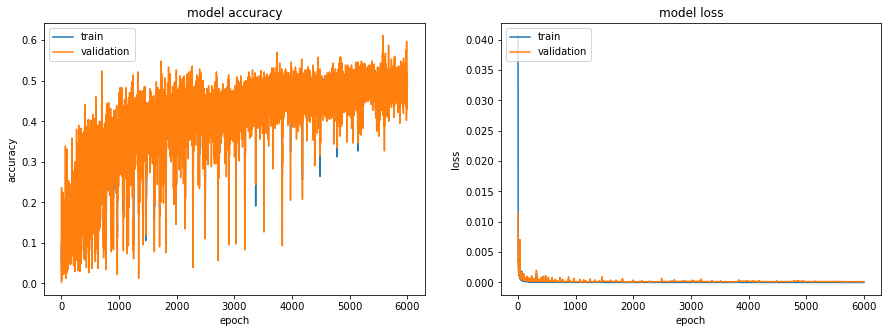

Epochs: 6000    Batch Size: 60    Optimitzer: Adam    Init LR: 0.001    Decay Step: 10000    Decay Rate: 0.9


In [72]:
os.chdir("E:\Documents\Projects\PycharmCurrent")

train_mse = model.evaluate(x_train, y_train, verbose=0)
test_mse = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print('#Train Data#     Loss: %.5f' % train_mse[0] + '    Accuracy: %.2f' % (train_mse[1]*100))
print('#Test  Data#     Loss: %.5f' % test_mse[0]  + '    Accuracy: %.2f' % (test_mse[1]*100))

# Plots
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Summarize history for accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.title.set_text('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig('accuracy.jpg')
plt.close()

print('Epochs: ' + str(n_epochs) + '    Batch Size: ' + str(batch_size) + '    Optimitzer: ' + str(optimizer._name)
      + '    Init LR: ' + str(init_lr) + '    Decay Step: ' + str(decay_stp) + '    Decay Rate: ' + str(decay_rt))

Store the Model

In [73]:
# Serialize model to JSON
model_json = model.to_json()
with open("E:\Documents\Projects\PycharmCurrent\MLmodel.json", "w") as json_file:
    json_file.write(model_json)
tfjs.converters.save_keras_model(model, "E:\Documents\Projects\PycharmCurrent\MLstuff")

FUTURE TASKS CODE

In [ ]:
# # Compute and store the result
# # TODO Use the data from the webcam
# result = model.predict(x_test, batch_size=batch_size)
# 
# with open("results.json", 'w') as file:
#     json.dump(result.tolist(), file, indent=4)
# 
# # Save the model
# filepath = 'saved_model'
# model.save(filepath)
# 
# # Load the model
# model = load_model(filepath, compile = True)